# **Mises au point diverses**

# Business analysis of clusters

De quoi j'ai besoin, pour quoi faire ?

* ✔ Commencer sur la base du cas k=3
* ✔ Besoin des classes et du tout, pour sortir des indicateurs par classe et globaux pour obtenir des indicateurs relatifs
* pour chaque classe :
    * ✔ nombre de clients
    * ✔ total des montants (CA)
    * période
    * ✔ dégrossissage hypercubique du domaine : intervalles de R, F, M
    * extension : intervalles pour d'autres features à envisager => envisager d'autres features => retour au feature engineering
    * description textuelle + pertinence
* mise en tableau + graphiques (monovariés, violin plots)
* boxplots par feature
* bivariées (et trivariées) par feature au sein de chaque classe => occasion d'utiliser Seaborn (permet de multiplier les dimensions représentées tout en restant compact)
* ✔ donner une représentation manuelle (abstraction manuelle)
* Utiliser des métriques de comparaison entre classes découvertes et classes manuelles
* ne pas perdre de vue le but : identifier les clients les plus intéressants

* features qui pourraient être pertinentes :
    * localisation géographique
    * reviews
    * ... réfléchir en revenant aux données sources, et avec de l'empathie
    * ex. périodes de l'année, comme les fêtes, l'été, l'hiver, etc


### Rappel des indications :
* **M37** [21/11] Pour chaque valeur « k » sélectionnée, vérification du nombre de clients par cluster. Si ce nombre est trop faible pour certains clusters (par exemple <500, pour 95 000 clients), la valeur « k » n’est pas pertinente d’un point de vue métier.
* **M38** [21/11] Si elle est pertinente, l’analyse se poursuit par l’analyse des clusters, afin de déterminer les profils de clients de chaque cluster et s’assurer de la pertinence de chaque cluster d’un point de vue métier, par exemple :
* **M39** [21/11] Pour chaque feature, un graphique de boxplot par cluster.
* **M310** [21/11] Et/ou inversement, pour chaque cluster un graphique de boxplot par feature (c’est complémentaire aux premiers graphiques).
* **M311** [21/11] Des graphiques d’analyse bivariée entre 2 features, ou 3D entre 3 features.
* **M312** [21/11] Pour chaque feature, un calcul de moyenne par cluster.
* **M313** [21/11] L’analyse des graphiques permet de formaliser un profil de clients par cluster, par exemple « cluster 0 = clients avec des montants élevés et une fréquence de commande élevée », etc.
* **M314** [21/11] Cette analyse permet de valider que chaque cluster décrit une typologie de clients qui a du sens d’un point de vue métier (dans notre cas, pour séparer les clients plus ou moins intéressants), et qui est différente des autres clusters.

### Mise au point avec k = 3

#### Data

In [1]:
import pandas as pd
from olist_commons import (
    get_last_order_date,
    get_customer_RFM,
)

crfm = get_customer_RFM(
    relative_to_date=get_last_order_date()
)
display(crfm.sort_values(by='R'))

# removing outliers
crfm_1 = crfm[(crfm.F < 8) & (crfm.M < 10_000)]

,R,F,M
customer_id,,,
87ab9fec999db8bd5774917de3cdf01c,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,18.345312,1,137.03
...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,764.087488,1,40.95


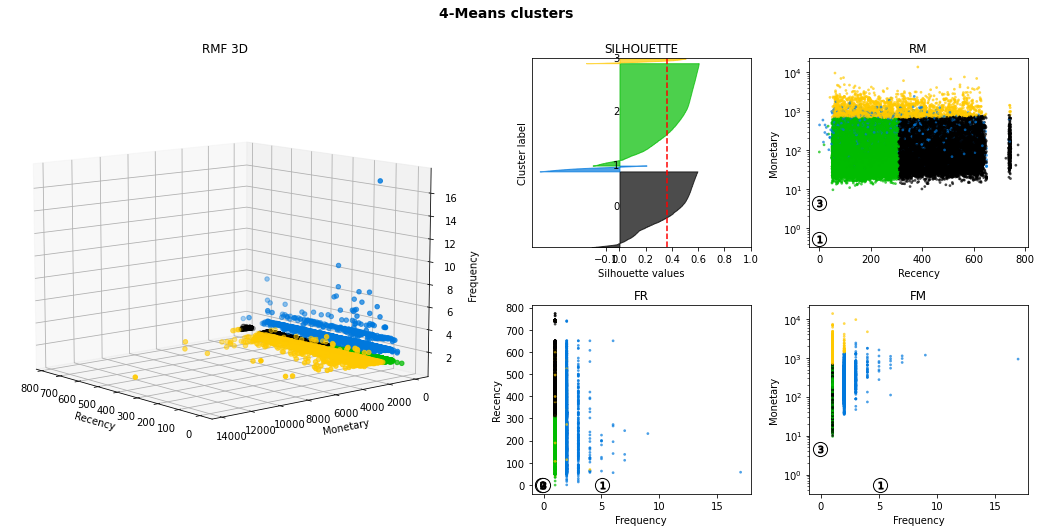

silhouette average : 0.365
k-means fit time : 2.747
silouhette compute time : 371.461


In [2]:
from olist_commons import kmeans_analysis_v2
(
    kmeans, clu_labels, clu_centers, slh_avg, km_t, slh_t
) = kmeans_analysis_v2(crfm, k=4, normalize=True)

#### Labeling

In [5]:
from olist_commons import insert_cl_labels
crfm_labeled = insert_cl_labels(crfm, clu_labels, name='k3_clu')
display(crfm_labeled)

,k3_clu,R,F,M
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2,160.273507,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,2,163.263090,1,27.19
0000f46a3911fa3c0805444483337064,0,585.850868,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,0,369.875428,1,43.62
0004aac84e0df4da2b147fca70cf8255,0,336.905972,1,196.89
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,3,495.853958,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,0,310.890532,1,84.58
ffff371b4d645b6ecea244b27531430a,0,617.070162,1,112.46


#### Cluster cardinalities

In [6]:
from olist_commons import get_cl_counts
display(get_cl_counts(crfm_labeled, name='k3_clu'))

2    52119
0    38595
1     2962
3     2420
Name: k3_clu, dtype: int64

#### Cluster per feature stats

In [7]:
gpby = crfm_labeled.groupby(by='k3_clu').agg(
    ['min', 'max', 'mean', 'median', 'std', 'skew', pd.Series.kurt]
)
print('Recency')
display(gpby.R)
print('Frequency')
display(gpby.F)
print('Monetary')
display(gpby.M)

Recency


,min,max,mean,median,std,skew,kurt
k3_clu,,,,,,,
0,308.138229,772.843738,438.487108,425.903356,96.634603,0.530784,-0.555179
1,0.884907,740.376262,268.771884,248.473773,145.390166,0.502824,-0.517085
2,0.000000,308.296412,177.981536,179.901690,72.863329,-0.042318,-1.186367
3,41.279236,742.920012,288.953272,274.013519,152.254740,0.431768,-0.691897


Frequency


,min,max,mean,median,std,skew,kurt
k3_clu,,,,,,,
0,1,1,1.000000,1.0,0.000000,0.000000,0.000000
1,2,17,2.116475,2.0,0.518101,11.772527,257.324178
2,1,1,1.000000,1.0,0.000000,0.000000,0.000000
3,1,4,1.015702,1.0,0.137002,10.595304,144.977567


Monetary


,min,max,mean,median,std,skew,kurt
k3_clu,,,,,,,
0,0.00,784.80,134.870848,101.730,110.761289,2.074551,5.271546
1,34.97,2400.48,290.305945,224.030,226.256947,2.489377,9.792896
2,0.00,703.06,135.223178,103.930,108.741203,2.000027,4.843126
3,654.41,13664.08,1196.673025,972.595,704.967242,5.469966,61.081511


#### Turnover

Total and mean by customer.

In [8]:
m_labeled = crfm_labeled[['k3_clu', 'M']]
m_gpby = m_labeled.groupby(by='k3_clu').agg(
    ['count', 'min', 'max', 'sum', 'mean', 'median', 'std', 'skew', pd.Series.kurt]
)
display(m_gpby.M)
turnover_abs = m_gpby.M['sum'].rename('toa')
turnover_rel = (turnover_abs / turnover_abs.sum()).rename('tor')
turnover = pd.concat([turnover_abs, turnover_rel], axis=1)
display(turnover)

,count,min,max,sum,mean,median,std,skew,kurt
k3_clu,,,,,,,,,
0,38595,0.00,784.80,5205340.38,134.870848,101.730,110.761289,2.074551,5.271546
1,2962,34.97,2400.48,859886.21,290.305945,224.030,226.256947,2.489377,9.792896
2,52119,0.00,703.06,7047696.81,135.223178,103.930,108.741203,2.000027,4.843126
3,2420,654.41,13664.08,2895948.72,1196.673025,972.595,704.967242,5.469966,61.081511


,toa,tor
k3_clu,,
0,5205340.38,0.325153
1,859886.21,0.053713
2,7047696.81,0.440237
3,2895948.72,0.180896


#### Hypercubic roughing of the domain

In [9]:
gpby_3 = crfm_labeled.groupby(by='k3_clu').agg(
    ['min', 'max']
)
display(gpby_3)

R               F           M          
               min         max min max     min       max
k3_clu                                                  
0       308.138229  772.843738   1   1    0.00    784.80
1         0.884907  740.376262   2  17   34.97   2400.48
2         0.000000  308.296412   1   1    0.00    703.06
3        41.279236  742.920012   1   4  654.41  13664.08

#### Manual stereotyping

* Frequency is not critical
* The classes mainly depend on a partition of the R and M domains

In [10]:
import numpy as np
classes_def = {
    0: {'R': [0, 300], 'M': [0, 600]},
    1: {'R': [300, np.inf], 'M': [0, 600]},
    2: {'R': [0, np.inf], 'M': [600, np.inf]},
}

In [12]:
from olist_commons import classes_labeling_v1
cla_labels = classes_labeling_v1(crfm, classes_def)
display(cla_labels)

customer_id
0000366f3b9a7992bf8c76cfdf3221e2    0
0000b849f77a49e4a4ce2b2a4ca5be3f    0
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    0
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: label, Length: 96096, dtype: int64

In [13]:
from olist_commons import insert_cl_labels
crfm_mlabeled = insert_cl_labels(crfm, cla_labels, name='k3_cla')
display(crfm_mlabeled)

,k3_cla,R,F,M
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,160.273507,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,0,163.263090,1,27.19
0000f46a3911fa3c0805444483337064,1,585.850868,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,1,369.875428,1,43.62
0004aac84e0df4da2b147fca70cf8255,1,336.905972,1,196.89
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,495.853958,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,1,310.890532,1,84.58
ffff371b4d645b6ecea244b27531430a,1,617.070162,1,112.46


In [14]:
from olist_commons import get_cl_counts
display(get_cl_counts(crfm_mlabeled, name='k3_cla'))

0    52089
1    40610
2     3397
Name: k3_cla, dtype: int64

### Mise en fonction avec k = 4

In [23]:
"""import pandas as pd
def classes_labeling(rfm, classes_def):
    label = pd.Series(data=-1, index=rfm.index, name='label')
    for c_id in classes_def:
        c_def = classes_def[c_id]
        c_bindex = (
              ((c_def['R'][0] <= rfm.R) & (rfm.R < c_def['R'][1]))
            & ((c_def['M'][0] <= rfm.M) & (rfm.M < c_def['M'][1]))
        )
        label[c_bindex] = c_id
    return label

import time
from sklearn.cluster import KMeans
def kmeans_clustering(crfm, k):
    km_t = -time.time()
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(crfm)
    km_t += time.time()
    clu_labels = kmeans.labels_
    clu_centers = kmeans.cluster_centers_
    rfm = r, f, m = crfm.R, crfm.F, crfm.M
    rfm_labels = r_label, f_label, m_label = 'Recency', 'Frequency', 'Monetary'
    rfm_centers = r_centers, f_centers, m_centers = (
        clu_centers[:, 0],
        clu_centers[:, 1],
        clu_centers[:, 2],
    )
    return kmeans, clu_labels, rfm, rfm_labels, rfm_centers, km_t

import pandas as pd
from pepper_commons import print_subtitle
def clusters_business_analysis(crfm, k, classes_def):
    # k-Means clustering
    kmeans, clu_labels, rfm, rfm_labels, rfm_centers, km_t = kmeans_clustering(crfm, k)
    r_label, f_label, m_label = rfm_labels
    # Labeling
    print_subtitle('Labeling')
    crfm_labeled = pd.concat([
        pd.Series(clu_labels, index=crfm.index, name='k_clu'),
        crfm
    ], axis=1)
    display(crfm_labeled)
    # Cluster cardinalities
    print_subtitle('Cluster cardinalities')
    clu_counts = crfm_labeled.k_clu.value_counts()
    display(clu_counts)
    # Cluster per feature stats
    print_subtitle('Cluster per feature stats')
    gpby = crfm_labeled.groupby(by='k_clu').agg(
        ['min', 'max', 'mean', 'median', 'std', 'skew', pd.Series.kurt]
    )
    print(r_label)
    display(gpby.R)
    print(m_label)
    display(gpby.M)
    print(f_label + ' (less pertinent)')
    display(gpby.F)

    # Turnover
    print_subtitle('Turnover')
    m_labeled = crfm_labeled[['k_clu', 'M']]
    m_gpby = m_labeled.groupby(by='k_clu').agg(
        ['count', 'min', 'max', 'sum', 'mean', 'median', 'std', 'skew', pd.Series.kurt]
    )
    turnover_abs = m_gpby.M['sum'].rename('toa')
    turnover_rel = (turnover_abs / turnover_abs.sum()).rename('tor')
    turnover = pd.concat([turnover_abs, turnover_rel], axis=1)
    display(turnover)
    display(m_gpby.M)
    # Hypercubic roughing of the domain
    print_subtitle('Hypercubic roughing of the domain')
    gpby_3 = crfm_labeled.groupby(by='k_clu').agg(
        ['min', 'max']
    )
    display(gpby_3)
    # Manual sterotyping
    import numpy as np
    print_subtitle('Manual sterotyping')
    cla_labels = classes_labeling(crfm, classes_def)
    crfm_mlabeled = pd.concat([
        pd.Series(cla_labels, index=crfm.index, name='k_cla'),
        crfm
    ], axis=1)
    display(crfm_mlabeled)
    # Compare cluster (machine learning) | classes (manual)
    print_subtitle('Compare cluster (machine learning) | classes (manual)')
    cla_counts = crfm_mlabeled.k_cla.value_counts()
    #display(cla_counts)
    cl_comp = pd.concat([clu_counts, cla_counts], axis=1)
    display(cl_comp)"""

In [16]:
from olist_commons import clusters_business_analysis
import numpy as np
classes_def = {
    0: {'R': [0, 308], 'M': [0, 400]},
    1: {'R': [0, np.inf], 'M': [400, 1200]},
    2: {'R': [0, np.inf], 'M': [1200, np.inf]},
    3: {'R': [308, np.inf], 'M': [0, 400]},
}
clusters_business_analysis(crfm, 4, classes_def)


Labeling


,k_clu,R,F,M
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,160.273507,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,163.263090,1,27.19
0000f46a3911fa3c0805444483337064,0,585.850868,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,0,369.875428,1,43.62
0004aac84e0df4da2b147fca70cf8255,0,336.905972,1,196.89
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,495.853958,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,0,310.890532,1,84.58
ffff371b4d645b6ecea244b27531430a,0,617.070162,1,112.46



Cluster cardinalities


1    51339
0    37941
3     6097
2      719
Name: k_clu, dtype: int64


Cluster per feature stats
Recency


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,308.384329,772.843738,438.984327,426.710891,96.375313,0.521774,-0.563741
1,0.000000,308.365359,177.753100,179.164734,73.008333,-0.038929,-1.188495
2,41.279236,741.170868,288.339510,271.794259,164.026350,0.421302,-0.893038
3,0.884907,743.042975,279.893716,262.946204,144.387661,0.535121,-0.346122


Monetary


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,0.00,467.20,121.360720,99.24,81.208076,1.232211,1.146917
1,0.00,404.82,121.295334,101.84,78.413862,1.092582,0.766042
2,1279.10,13664.08,1930.797344,1675.71,924.395441,5.455293,48.740500
3,358.04,1276.52,621.436876,559.23,216.295715,1.066891,0.406388


Frequency (less pertinent)


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,1,6,1.024881,1.0,0.165606,7.566494,75.451536
1,1,5,1.029549,1.0,0.179936,6.641602,51.180744
2,1,5,1.089013,1.0,0.377470,5.457797,36.299094
3,1,17,1.134492,1.0,0.503224,9.405744,195.348246



Turnover


,toa,tor
k_clu,,
0,4604547.07,0.287625
1,6227181.13,0.388983
2,1388243.29,0.086717
3,3788900.63,0.236675


,count,min,max,sum,mean,median,std,skew,kurt
k_clu,,,,,,,,,
0,37941,0.00,467.20,4604547.07,121.360720,99.24,81.208076,1.232211,1.146917
1,51339,0.00,404.82,6227181.13,121.295334,101.84,78.413862,1.092582,0.766042
2,719,1279.10,13664.08,1388243.29,1930.797344,1675.71,924.395441,5.455293,48.740500
3,6097,358.04,1276.52,3788900.63,621.436876,559.23,216.295715,1.066891,0.406388



Hypercubic roughing of the domain


R               F            M          
              min         max min max      min       max
k_clu                                                   
0      308.384329  772.843738   1   6     0.00    467.20
1        0.000000  308.365359   1   5     0.00    404.82
2       41.279236  741.170868   1   5  1279.10  13664.08
3        0.884907  743.042975   1  17   358.04   1276.52


Manual sterotyping


,k_cla,R,F,M
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0,160.273507,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,0,163.263090,1,27.19
0000f46a3911fa3c0805444483337064,3,585.850868,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,3,369.875428,1,43.62
0004aac84e0df4da2b147fca70cf8255,3,336.905972,1,196.89
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2,495.853958,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,3,310.890532,1,84.58
ffff371b4d645b6ecea244b27531430a,3,617.070162,1,112.46



Compare cluster (machine learning) | classes (manual)


,k_clu,k_cla
1,51339,5585
0,37941,51547
3,6097,38118
2,719,846


### k = 5

In [73]:
from olist_commons import clusters_business_analysis
import numpy as np
classes_def = {
    0: {'R': [310, np.inf], 'M': [0, 360]},
    1: {'R': [0, 310], 'M': [0, 360]},
    2: {'R': [0, np.inf], 'M': [1620, np.inf]},
    3: {'R': [0, np.inf], 'M': [660, 1620]},
    4: {'R': [0, np.inf], 'M': [360, 660]},
}
clusters_business_analysis(crfm_1, 5, classes_def)


Labeling


,k_clu,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,1,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,4,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,4,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,1,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,1,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,0,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,0,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,0,764.087488,1,40.95



Cluster cardinalities


1    48038
0    35238
4    10062
3     2346
2      409
Name: k_clu, dtype: int64


Cluster per feature stats
Recency


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,309.757951,772.843738,444.563120,433.774346,96.004508,0.475290,-0.589987
1,0.000000,312.390231,178.051196,178.892847,73.990394,-0.013003,-1.183707
2,41.279236,629.042222,288.160621,261.903866,167.634933,0.406532,-1.071030
3,48.302986,743.042975,298.041893,279.075637,158.330378,0.438196,-0.666260
4,0.884907,742.200463,264.214200,258.315515,123.428271,0.456175,-0.105047


Monetary


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,0.00,467.20,110.114013,94.08,67.234708,1.141956,1.317001
1,0.00,295.57,106.057999,94.40,58.979005,0.657121,-0.396042
2,1619.73,9553.02,2292.185746,2029.62,909.712028,3.699716,18.847371
3,651.32,1620.77,947.855281,872.69,241.360213,0.871215,-0.259062
4,217.64,676.16,383.315796,356.14,109.869859,0.783377,-0.289470


Frequency (less pertinent)


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,1,6,1.021766,1.0,0.154976,8.169107,90.260381
1,1,3,1.022794,1.0,0.155667,7.157102,54.833263
2,1,4,1.088020,1.0,0.379729,5.226378,30.752658
3,1,7,1.120631,1.0,0.485553,6.244270,52.330895
4,1,6,1.113298,1.0,0.370737,4.076239,22.968623



Turnover


,toa,tor
k_clu,,
0,3880197.60,0.242617
1,5094814.15,0.318563
2,937503.97,0.058619
3,2223668.49,0.139039
4,3856923.54,0.241162


,count,min,max,sum,mean,median,std,skew,kurt
k_clu,,,,,,,,,
0,35238,0.00,467.20,3880197.60,110.114013,94.08,67.234708,1.141956,1.317001
1,48038,0.00,295.57,5094814.15,106.057999,94.40,58.979005,0.657121,-0.396042
2,409,1619.73,9553.02,937503.97,2292.185746,2029.62,909.712028,3.699716,18.847371
3,2346,651.32,1620.77,2223668.49,947.855281,872.69,241.360213,0.871215,-0.259062
4,10062,217.64,676.16,3856923.54,383.315796,356.14,109.869859,0.783377,-0.289470



Hypercubic roughing of the domain


R               F            M         
              min         max min max      min      max
k_clu                                                  
0      309.757951  772.843738   1   6     0.00   467.20
1        0.000000  312.390231   1   3     0.00   295.57
2       41.279236  629.042222   1   4  1619.73  9553.02
3       48.302986  743.042975   1   7   651.32  1620.77
4        0.884907  742.200463   1   6   217.64   676.16


Manual sterotyping


,k_cla,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,1,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,4,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,4,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,1,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,1,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,0,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,0,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,0,764.087488,1,40.95



Compare cluster (machine learning) | classes (manual)


,k_clu,k_cla
1,48038,51245
0,35238,37050
4,10062,5011
3,2346,2378
2,409,409


### k = 6

In [74]:
from olist_commons import clusters_business_analysis
import numpy as np
classes_def = {
    0: {'R': [310, np.inf], 'M': [0, 360]},
    1: {'R': [0, 310], 'M': [0, 360]},
    2: {'R': [0, np.inf], 'M': [1620, np.inf]},
    3: {'R': [0, np.inf], 'M': [660, 1620]},
    4: {'R': [0, np.inf], 'M': [360, 660]},
    5: {'R': [0, np.inf], 'M': [360, 660]},
}
clusters_business_analysis(crfm_1, 6, classes_def)


Labeling


,k_clu,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,5,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,0,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,0,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,5,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,5,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,1,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,1,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,1,764.087488,1,40.95



Cluster cardinalities


5    32408
3    31768
1    20713
0     8849
2     2015
4      340
Name: k_clu, dtype: int64


Cluster per feature stats
Recency


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,0.884907,743.042975,266.996898,254.848762,126.305222,0.482823,-0.134589
1,398.062234,772.843738,510.465269,503.305486,69.137693,0.630146,0.146295
2,48.302986,742.920012,295.722258,276.166146,157.795653,0.421643,-0.760464
3,215.773218,413.814769,304.891667,307.194294,52.106164,0.182028,-1.031276
4,41.279236,629.042222,278.326918,230.950839,170.191663,0.506689,-1.022725
5,0.000000,227.289062,135.216404,135.065995,49.869857,-0.001333,-1.286662


Monetary


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,254.88,728.74,418.030364,384.270,118.618600,0.797179,-0.388312
1,0.00,534.98,118.261169,98.200,76.997141,1.208293,1.287609
2,705.26,1719.92,1023.590268,937.640,257.019923,0.865001,-0.250945
3,10.07,271.08,104.049552,91.035,58.416087,0.713592,-0.347604
4,1724.04,9553.02,2420.710647,2106.060,947.454954,3.595055,17.282757
5,0.00,332.92,112.731155,99.330,64.869525,0.735903,-0.194647


Frequency (less pertinent)


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,1,6,1.115945,1.0,0.379314,4.112493,23.260691
1,1,6,1.023174,1.0,0.163382,8.473161,101.871251
2,1,7,1.125062,1.0,0.502469,6.265702,51.869601
3,1,3,1.021531,1.0,0.149423,7.151374,53.637046
4,1,4,1.097059,1.0,0.405701,4.996604,27.580751
5,1,4,1.026105,1.0,0.167748,6.825242,50.992527



Turnover


,toa,tor
k_clu,,
0,3699150.69,0.231297
1,2449543.60,0.153162
2,2062534.39,0.128964
3,3305446.18,0.206679
4,823041.62,0.051462
5,3653391.27,0.228435


,count,min,max,sum,mean,median,std,skew,kurt
k_clu,,,,,,,,,
0,8849,254.88,728.74,3699150.69,418.030364,384.270,118.618600,0.797179,-0.388312
1,20713,0.00,534.98,2449543.60,118.261169,98.200,76.997141,1.208293,1.287609
2,2015,705.26,1719.92,2062534.39,1023.590268,937.640,257.019923,0.865001,-0.250945
3,31768,10.07,271.08,3305446.18,104.049552,91.035,58.416087,0.713592,-0.347604
4,340,1724.04,9553.02,823041.62,2420.710647,2106.060,947.454954,3.595055,17.282757
5,32408,0.00,332.92,3653391.27,112.731155,99.330,64.869525,0.735903,-0.194647



Hypercubic roughing of the domain


R               F            M         
              min         max min max      min      max
k_clu                                                  
0        0.884907  743.042975   1   6   254.88   728.74
1      398.062234  772.843738   1   6     0.00   534.98
2       48.302986  742.920012   1   7   705.26  1719.92
3      215.773218  413.814769   1   3    10.07   271.08
4       41.279236  629.042222   1   4  1724.04  9553.02
5        0.000000  227.289062   1   4     0.00   332.92


Manual sterotyping


,k_cla,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,1,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,5,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,5,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,1,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,1,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,0,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,0,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,0,764.087488,1,40.95



Compare cluster (machine learning) | classes (manual)


,k_clu,k_cla
5,32408,5011.0
3,31768,2378.0
1,20713,51245.0
0,8849,37050.0
2,2015,409.0
4,340,NaN


### k = 7

In [32]:
import numpy as np
classes_def = {
    0: {'R': [310, np.inf], 'M': [0, 360]},
    1: {'R': [0, 310], 'M': [0, 360]},
    2: {'R': [0, np.inf], 'M': [1620, np.inf]},
    3: {'R': [0, np.inf], 'M': [660, 1620]},
    4: {'R': [0, np.inf], 'M': [360, 660]},
    5: {'R': [0, np.inf], 'M': [360, 660]},
    6: {'R': [0, np.inf], 'M': [360, 660]},
}
clusters_business_analysis(crfm_1, 7, classes_def)


Labeling


,k_clu,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,6,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,5,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,0,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,6,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,6,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,2,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,2,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,2,764.087488,1,40.95



Cluster cardinalities


6    31237
1    30491
2    20625
5     9919
0     2965
4      772
3       84
Name: k_clu, dtype: int64


Cluster per feature stats
Recency


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,13.940845,743.042975,297.781334,278.694931,155.031749,0.465598,-0.591216
1,216.286030,418.260810,306.180818,308.805532,52.519959,0.177793,-1.026815
2,394.960486,772.843738,511.512771,504.712859,68.851277,0.622898,0.151639
3,60.891458,624.019815,313.688182,302.217535,188.026128,0.247156,-1.474319
4,41.279236,742.134606,291.572852,278.467326,159.462187,0.372063,-0.830064
5,0.884907,609.256736,248.728624,240.249028,109.142671,0.315730,-0.387353
6,0.000000,225.370313,134.683571,134.237454,49.820195,0.011672,-1.286443


Monetary


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,518.50,1185.58,763.112034,720.980,163.999261,0.744501,-0.417726
1,10.07,245.35,97.847994,87.160,51.969734,0.594795,-0.594733
2,0.00,534.98,119.853604,99.670,79.311810,1.308122,1.787671
3,2606.01,9553.02,3593.426786,3099.425,1295.755587,2.446905,6.552141
4,1186.58,2590.61,1610.298899,1500.820,345.240925,0.780558,-0.421888
5,209.20,572.87,342.844208,325.370,86.104778,0.630901,-0.470451
6,0.00,289.39,106.583427,95.650,58.276328,0.613102,-0.459619


Frequency (less pertinent)


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,1,7,1.125801,1.0,0.483212,5.900479,47.473354
1,1,3,1.019350,1.0,0.141512,7.527080,59.354798
2,1,6,1.023370,1.0,0.164300,8.448280,100.959196
3,1,4,1.130952,1.0,0.459957,4.301316,21.023151
4,1,5,1.099741,1.0,0.393395,4.966661,29.899740
5,1,6,1.108176,1.0,0.354006,3.907751,20.500884
6,1,3,1.022890,1.0,0.156254,7.169181,55.141215



Turnover


,toa,tor
k_clu,,
0,2262627.18,0.141475
1,2983483.18,0.186548
2,2471980.58,0.154565
3,301847.85,0.018874
4,1243150.75,0.077730
5,3400671.70,0.212634
6,3329346.51,0.208174


,count,min,max,sum,mean,median,std,skew,kurt
k_clu,,,,,,,,,
0,2965,518.50,1185.58,2262627.18,763.112034,720.980,163.999261,0.744501,-0.417726
1,30491,10.07,245.35,2983483.18,97.847994,87.160,51.969734,0.594795,-0.594733
2,20625,0.00,534.98,2471980.58,119.853604,99.670,79.311810,1.308122,1.787671
3,84,2606.01,9553.02,301847.85,3593.426786,3099.425,1295.755587,2.446905,6.552141
4,772,1186.58,2590.61,1243150.75,1610.298899,1500.820,345.240925,0.780558,-0.421888
5,9919,209.20,572.87,3400671.70,342.844208,325.370,86.104778,0.630901,-0.470451
6,31237,0.00,289.39,3329346.51,106.583427,95.650,58.276328,0.613102,-0.459619



Hypercubic roughing of the domain


R               F            M         
              min         max min max      min      max
k_clu                                                  
0       13.940845  743.042975   1   7   518.50  1185.58
1      216.286030  418.260810   1   3    10.07   245.35
2      394.960486  772.843738   1   6     0.00   534.98
3       60.891458  624.019815   1   4  2606.01  9553.02
4       41.279236  742.134606   1   5  1186.58  2590.61
5        0.884907  609.256736   1   6   209.20   572.87
6        0.000000  225.370313   1   3     0.00   289.39


Manual sterotyping


,k_cla,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,1,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,6,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,6,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,1,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,1,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,0,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,0,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,0,764.087488,1,40.95



Compare cluster (machine learning) | classes (manual)


,k_clu,k_cla
6,31237,5011.0
1,30491,51245.0
2,20625,409.0
5,9919,NaN
0,2965,37050.0
4,772,NaN
3,84,2378.0


### k = 8

In [33]:
import numpy as np
classes_def = {
    0: {'R': [310, np.inf], 'M': [0, 360]},
    1: {'R': [0, 310], 'M': [0, 360]},
    2: {'R': [0, np.inf], 'M': [1620, np.inf]},
    3: {'R': [0, np.inf], 'M': [660, 1620]},
    4: {'R': [0, np.inf], 'M': [360, 660]},
    5: {'R': [0, np.inf], 'M': [360, 660]},
    6: {'R': [0, np.inf], 'M': [360, 660]},
    7: {'R': [0, np.inf], 'M': [360, 660]},
}
clusters_business_analysis(crfm_1, 8, classes_def)


Labeling


,k_clu,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,0,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,5,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,2,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,0,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,0,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,1,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,1,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,1,764.087488,1,40.95



Cluster cardinalities


4    29815
0    28555
1    18210
5     9281
6     6346
2     3023
3      779
7       84
Name: k_clu, dtype: int64


Cluster per feature stats
Recency


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,0.000000,220.399549,134.571619,134.097454,49.796933,0.007057,-1.294596
1,407.939062,772.843738,511.879108,504.935382,69.040848,0.624112,0.145188
2,13.940845,742.920012,282.983377,263.722315,145.721479,0.541331,-0.404049
3,41.279236,742.134606,292.293818,279.058970,159.189298,0.364352,-0.831337
4,218.776088,408.390150,304.735732,307.177975,51.400941,0.182325,-1.005743
5,0.884907,305.144259,172.589934,175.354062,66.500945,-0.061337,-1.073969
6,292.218588,743.240475,430.713245,416.939138,89.808849,0.624088,-0.196719
7,60.891458,624.019815,313.688182,302.217535,188.026128,0.247156,-1.474319


Monetary


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,0.00,214.48,94.957003,87.810,47.681401,0.430606,-0.828309
1,0.00,299.84,95.919985,85.140,50.691660,0.679077,-0.245123
2,516.73,1180.51,756.666328,715.170,165.061105,0.726711,-0.429551
3,1181.11,2590.61,1606.463877,1493.450,346.039012,0.784588,-0.413659
4,10.07,238.72,97.473324,87.800,50.466820,0.538548,-0.657132
5,185.35,566.79,300.116173,274.560,87.536149,0.936371,0.030533
6,182.98,663.93,315.580952,297.620,87.952087,0.849346,0.190602
7,2606.01,9553.02,3593.426786,3099.425,1295.755587,2.446905,6.552141


Frequency (less pertinent)


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,1,3,1.018035,1.0,0.137991,7.989837,68.171392
1,1,6,1.017408,1.0,0.142447,10.329691,161.978407
2,1,7,1.126365,1.0,0.488020,5.934474,47.673549
3,1,5,1.101412,1.0,0.394350,4.904008,29.273456
4,1,3,1.019151,1.0,0.140921,7.584628,60.394470
5,1,5,1.103329,1.0,0.343647,3.848470,18.685382
6,1,4,1.076741,1.0,0.290003,4.080533,18.635865
7,1,4,1.130952,1.0,0.459957,4.301316,21.023151



Turnover


,toa,tor
k_clu,,
0,2711497.22,0.169542
1,1746702.93,0.109216
2,2287402.31,0.143024
3,1251435.36,0.078248
4,2906167.16,0.181714
5,2785378.20,0.174161
6,2002676.72,0.125221
7,301847.85,0.018874


,count,min,max,sum,mean,median,std,skew,kurt
k_clu,,,,,,,,,
0,28555,0.00,214.48,2711497.22,94.957003,87.810,47.681401,0.430606,-0.828309
1,18210,0.00,299.84,1746702.93,95.919985,85.140,50.691660,0.679077,-0.245123
2,3023,516.73,1180.51,2287402.31,756.666328,715.170,165.061105,0.726711,-0.429551
3,779,1181.11,2590.61,1251435.36,1606.463877,1493.450,346.039012,0.784588,-0.413659
4,29815,10.07,238.72,2906167.16,97.473324,87.800,50.466820,0.538548,-0.657132
5,9281,185.35,566.79,2785378.20,300.116173,274.560,87.536149,0.936371,0.030533
6,6346,182.98,663.93,2002676.72,315.580952,297.620,87.952087,0.849346,0.190602
7,84,2606.01,9553.02,301847.85,3593.426786,3099.425,1295.755587,2.446905,6.552141



Hypercubic roughing of the domain


R               F            M         
              min         max min max      min      max
k_clu                                                  
0        0.000000  220.399549   1   3     0.00   214.48
1      407.939062  772.843738   1   6     0.00   299.84
2       13.940845  742.920012   1   7   516.73  1180.51
3       41.279236  742.134606   1   5  1181.11  2590.61
4      218.776088  408.390150   1   3    10.07   238.72
5        0.884907  305.144259   1   5   185.35   566.79
6      292.218588  743.240475   1   4   182.98   663.93
7       60.891458  624.019815   1   4  2606.01  9553.02


Manual sterotyping


,k_cla,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,1,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,7,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,7,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,1,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,1,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,0,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,0,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,0,764.087488,1,40.95



Compare cluster (machine learning) | classes (manual)


,k_clu,k_cla
4,29815,NaN
0,28555,37050.0
1,18210,51245.0
5,9281,NaN
6,6346,NaN
2,3023,409.0
3,779,2378.0
7,84,5011.0


## Abstracteur de classes

L'objectif est de dériver automatiquement les classes (abstractions liénaires) partant des clusters.

Les abstractions se font sur le plan principal (TODO à confirmer avec une PCA) des dimensions M et R.

La première abstraction est la suivante :
* Les classes sont d'abord des subdivisions de M en intervalles disjoints
* puis, pour le plut petit intervalle [0, x], des subdivisions de R

Pour déterminer les limites, on prend la médiane des points limites

En bonus, les jolis diagrammes de densité 2D avec distribution marginale que l'on trouve dans SNS

On démarre avec k = 3, puis on passe à k = 9

14/12 : amorce, mais le problème est moins facile qu'il n'y parait.

D'abord, trouver les min et max par intervalles linspace n'est pas la bonne approche.

Il faut plutôt une décomposition de l'intervalle R en quantiles, sinon, un intervalle peut être moins représenté voire vide ...

Ensuite... hum, pas simple de séparer les classes

In [10]:
from pepper_commons import print_subtitle
from olist_commons import kmeans_clustering
crfm = crfm_1
k = 3

# k-Means clustering
kmeans, clu_labels, rfm, rfm_labels, rfm_centers, km_t = kmeans_clustering(crfm, k)
r_label, f_label, m_label = rfm_labels
# Labeling
print_subtitle('Labeling')
crfm_labeled = pd.concat([
    pd.Series(clu_labels, index=crfm.index, name='k_clu'),
    crfm
], axis=1)
display(crfm_labeled)
# Cluster cardinalities
print_subtitle('Cluster cardinalities')
clu_counts = crfm_labeled.k_clu.value_counts()
display(clu_counts)
# Cluster per feature stats
print_subtitle('Cluster per feature stats')
gpby = crfm_labeled.groupby(by='k_clu').agg(
    ['min', 'max', 'mean', 'median', 'std', 'skew', pd.Series.kurt]
)
print(r_label)
display(gpby.R)
print(m_label)
display(gpby.M)
print(f_label + ' (less pertinent)')
display(gpby.F)

# Turnover
print_subtitle('Turnover')
m_labeled = crfm_labeled[['k_clu', 'M']]
m_gpby = m_labeled.groupby(by='k_clu').agg(
    ['count', 'min', 'max', 'sum', 'mean', 'median', 'std', 'skew', pd.Series.kurt]
)
turnover_abs = m_gpby.M['sum'].rename('toa')
turnover_rel = (turnover_abs / turnover_abs.sum()).rename('tor')
turnover = pd.concat([turnover_abs, turnover_rel], axis=1)
display(turnover)
display(m_gpby.M)
# Hypercubic roughing of the domain
print_subtitle('Hypercubic roughing of the domain')
gpby_3 = crfm_labeled.groupby(by='k_clu').agg(
    ['min', 'max']
)


Labeling


,k_clu,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,0,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,0,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,0,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,0,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,0,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,1,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,1,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,1,764.087488,1,40.95



Cluster cardinalities


0    53295
1    39430
2     3368
Name: k_clu, dtype: int64


Cluster per feature stats
Recency


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,0.000000,311.036539,177.455932,179.069028,72.667174,-0.043665,-1.188516
1,306.140394,772.843738,437.553144,424.951163,96.493596,0.533821,-0.554942
2,41.279236,743.042975,292.188675,276.889635,154.066471,0.457577,-0.612687


Monetary


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,0.00,613.15,135.732119,106.50,103.895303,1.716305,3.288748
1,0.00,628.35,132.196006,102.03,101.332291,1.727816,3.311223
2,585.64,9553.02,1053.080748,850.28,606.533994,4.128612,31.602059


Frequency (less pertinent)


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,1,6,1.034112,1.0,0.198031,6.770327,59.707468
1,1,6,1.027974,1.0,0.176919,7.211765,67.293829
2,1,7,1.118765,1.0,0.471490,6.009883,48.804734



Turnover


,toa,tor
k_clu,,
0,7233843.26,0.452310
1,5212488.53,0.325921
2,3546775.96,0.221769


,count,min,max,sum,mean,median,std,skew,kurt
k_clu,,,,,,,,,
0,53295,0.00,613.15,7233843.26,135.732119,106.50,103.895303,1.716305,3.288748
1,39430,0.00,628.35,5212488.53,132.196006,102.03,101.332291,1.727816,3.311223
2,3368,585.64,9553.02,3546775.96,1053.080748,850.28,606.533994,4.128612,31.602059



Hypercubic roughing of the domain


In [29]:
crfm_labeled_3_2 = crfm_labeled[crfm_labeled.k_clu == 2]
#display(crfm_labeled_3_2)
#crfm_labeled_3_2.plot.scatter(x='R', y='M')

r_min = crfm_labeled_3_2.R.min()
r_max = crfm_labeled_3_2.R.max()
delta_r = r_max - r_min

import numpy as np
n = 20
bins = np.linspace(r_min, r_max, n + 1)
print(bins)
m_mins = []
m_maxs = []
for k, a in enumerate(bins):
    if k == n:
        break
    b = bins[k + 1]
    print(k, '[', a, ', ', b, '[')
    crfm_labeled_3_2_a_b = crfm_labeled_3_2[
          (a <= crfm_labeled_3_2.R)
        & (crfm_labeled_3_2.R < b)
    ]
    m_mins += [crfm_labeled_3_2_a_b.M.min()]
    m_maxs += [crfm_labeled_3_2_a_b.M.max()]
    print('\tm_min : ', m_mins[k])
    print('\tm_max : ', m_maxs[k])
print('M min :', np.median(m_mins))
print('M max :', np.median(m_maxs))

[ 41.27923611  76.36742303 111.45560995 146.54379687 181.6319838
 216.72017072 251.80835764 286.89654456 321.98473148 357.0729184
 392.16110532 427.24929225 462.33747917 497.42566609 532.51385301
 567.60203993 602.69022685 637.77841377 672.86660069 707.95478762
 743.04297454]
0 [ 41.27923611111111 ,  76.3674230324074 [
	m_min :  616.5
	m_max :  9553.02
1 [ 76.3674230324074 ,  111.45560995370371 [
	m_min :  614.63
	m_max :  7274.88
2 [ 111.45560995370371 ,  146.543796875 [
	m_min :  607.98
	m_max :  4681.78
3 [ 146.543796875 ,  181.6319837962963 [
	m_min :  603.3
	m_max :  3979.55
4 [ 181.6319837962963 ,  216.72017071759262 [
	m_min :  599.3
	m_max :  4175.26
5 [ 216.72017071759262 ,  251.8083576388889 [
	m_min :  597.14
	m_max :  3358.24
6 [ 251.8083576388889 ,  286.8965445601852 [
	m_min :  591.56
	m_max :  3826.8
7 [ 286.8965445601852 ,  321.9847314814815 [
	m_min :  585.64
	m_max :  3297.3999999999996
8 [ 321.9847314814815 ,  357.0729184027778 [
	m_min :  589.05
	m_max :  6081.54
9 

### Aide ChatGPT

Le but est de dériver des classes abstraites à partir de clusters obtenus en utilisant l'algorithme de k-means. Ces classes doivent former une partition de l'espace sous forme d'hypercubes disjoints.

In [105]:
from typing import List, Tuple

def cluster_to_abstract_class(
    cluster: List[List[float]]
) -> Tuple[Tuple[float, float], Tuple[float, float], Tuple[float, float]]:
    # Initialiser les intervalles minimaux et maximaux à des valeurs extrêmes
    min_intervals = [float("inf"), float("inf"), float("inf")]
    max_intervals = [float("-inf"), float("-inf"), float("-inf")]
    
    # Pour chaque point du cluster
    for point in cluster:
        # Mettre à jour les intervalles minimaux et maximaux si nécessaire
        for i in range(3):
            min_intervals[i] = min(min_intervals[i], point[i])
            max_intervals[i] = max(max_intervals[i], point[i])
    
    # Renvoyer les intervalles sous forme de tuples
    return tuple(zip(min_intervals, max_intervals))


def insert_clu_labels(crfm, clu_labels):
    return pd.concat([
        pd.Series(clu_labels, index=crfm_1.index, name='k_clu'),
        crfm_1
    ], axis=1)


def get_cluster(crfm_labeled, clu_index):
    clu = crfm_labeled[crfm_labeled.k_clu == clu_index]
    return clu[['R', 'F', 'M']]


def get_abstracted_classes(crfm, clu_labels):
    k_values = np.unique(clu_labels)
    crfm_labeled = insert_clu_labels(crfm, clu_labels)
    return {
        k: cluster_to_abstract_class(get_cluster(crfm_labeled, k).values)
        for k in k_values
    }
    

In [97]:
from olist_commons import kmeans_clustering_v2
(
    kmeans, clu_labels, clu_centers, km_t
) = kmeans_clustering_v2(crfm_1, 3)

,k_clu,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,0,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,0,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,0,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,0,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,0,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,1,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,1,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,1,764.087488,1,40.95


In [99]:
import numpy as np
classes_def = {
    0: {'R': [0, 300], 'M': [0, 600]},
    1: {'R': [300, np.inf], 'M': [0, 600]},
    2: {'R': [0, np.inf], 'M': [600, np.inf]},
}

In [106]:
display(get_abstracted_classes(crfm_1, clu_labels))

{0: ((0.0, 311.03653935185184), (1.0, 6.0), (0.0, 613.15)),
 1: ((306.1403935185185, 772.843738425926), (1.0, 6.0), (0.0, 628.35)),
 2: ((41.27923611111111, 743.042974537037), (1.0, 7.0), (585.64, 9553.02))}

### Visualisation clusters => classes

In [107]:
plot_clusters_rm_proj(k, rfm, rfm_labels, clu_labels, clu_centers)

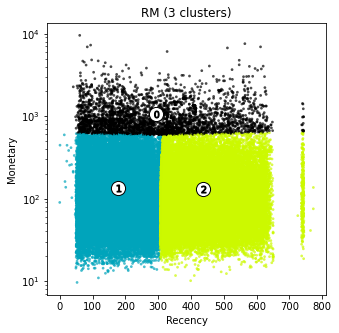

In [5]:
r_centers = m_centers = None  # pour que ça passe le check

import matplotlib.pyplot as plt
from olist_commons import plot_clusters_2d
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plt.semilogy()
plot_clusters_2d(
    ax, f'RM ({k} clusters)',
    xy=[r, m], xy_labels=[r_label, m_label],
    xy_clu_centers=[r_centers, m_centers],
    clu_labels=clu_labels
)

##### Class labeling

In [6]:
from olist_commons import classes_labeling_v1
import numpy as np
classes_def = {
    0: {'R': [0, np.inf], 'M': [600, np.inf]},
    1: {'R': [0, 300], 'M': [0, 600]},
    2: {'R': [300, np.inf], 'M': [0, 600]},
}
cla_labels = classes_labeling_v1(crfm_1, classes_def)
display(cla_labels)

customer_unique_id
87ab9fec999db8bd5774917de3cdf01c    1
262e1f1e26e92e86375f86840b4ffd63    1
af5454198a97379394cacf676e1e96cb    1
634420a0ea42302205032ed44ac7fccc    1
9bb92bebd4cb7511e1a02d5e50bc4655    1
                                   ..
0eb1ee9dba87f5b36b4613a65074337c    2
830d5b7aaa3b6f1e9ad63703bec97d23    2
009b0127b727ab0ba422f6d9604487c7    2
4854e9b3feff728c13ee5fc7d1547e92    2
b7d76e111c89f7ebf14761390f0f7d17    2
Name: label, Length: 96093, dtype: int64

In [ ]:
def classes_labeling(rfm, classes_def):
    pass

#### Class centers

Les centres sont les barycentres, d'où le nom de l'algorithme.

Réalisation de la fonction et test sur les clusters, puis application aux classes.

In [8]:
crfm_clu_labeled = pd.concat([
    pd.Series(clu_labels, index=crfm_1.index, name='k_clu'),
    crfm_1
], axis=1)
display(crfm_clu_labeled)

,k_clu,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,1,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,1,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,1,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,1,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,1,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,2,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,2,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,2,764.087488,1,40.95


In [9]:
cla_labels = classes_labeling(crfm_1, classes_def)
crfm_cla_labeled = pd.concat([
    pd.Series(cla_labels, index=crfm_1.index, name='k_cla'),
    crfm_1
], axis=1)
display(crfm_cla_labeled)

,k_cla,R,F,M
customer_unique_id,,,,
87ab9fec999db8bd5774917de3cdf01c,1,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,1,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,1,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,1,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,1,18.345312,1,137.03
...,...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,2,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,2,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,2,764.087488,1,40.95


In [10]:
clu_means = crfm_clu_labeled.groupby(by='k_clu').mean()
display(clu_means)

,R,F,M
k_clu,,,
0,292.188675,1.118765,1053.080748
1,177.455932,1.034112,135.732119
2,437.553144,1.027974,132.196006


In [11]:
display(clu_centers)

array([[2.92086275e+02, 1.11860880e+00, 1.05360901e+03],
       [1.77459962e+02, 1.03411010e+00, 1.35754056e+02],
       [4.37561476e+02, 1.02799828e+00, 1.32214435e+02]])

In [14]:
cla_means = crfm_cla_labeled.groupby(by='k_cla').mean()
display(cla_means)
display(cla_means.values)
cla_centers = cla_means.values

,R,F,M
k_cla,,,
0,294.731177,1.119034,1049.823771
1,174.579252,1.034057,135.252236
2,433.399398,1.028146,132.599166


array([[2.94731177e+02, 1.11903359e+00, 1.04982377e+03],
       [1.74579252e+02, 1.03405709e+00, 1.35252236e+02],
       [4.33399398e+02, 1.02814578e+00, 1.32599166e+02]])

In [15]:
rfm_centers = r_centers, f_centers, m_centers = (
    cla_centers[:, 0],
    cla_centers[:, 1],
    cla_centers[:, 2],
) 

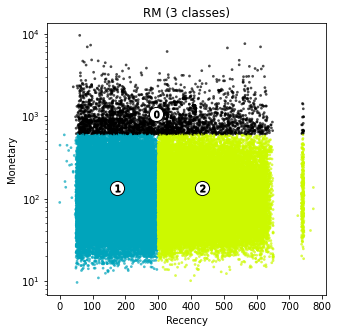

In [16]:
import matplotlib.pyplot as plt
from olist_commons import plot_clusters_2d
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
plt.semilogy()
plot_clusters_2d(
    ax, f'RM ({k} classes)',
    xy=[r, m], xy_labels=[r_label, m_label],
    xy_clu_centers=[r_centers, m_centers],
    clu_labels=cla_labels
)

### Intégration en une fonction unique

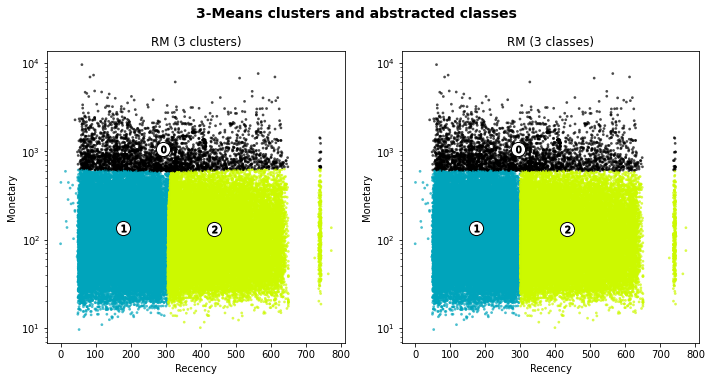

In [25]:
def get_centers(crfm, cl_labels):
    crfm_cl_labeled = pd.concat([
        pd.Series(cl_labels, index=crfm.index, name='k_cl'),
        crfm
    ], axis=1)
    cl_means = crfm_cl_labeled.groupby(by='k_cl').mean()
    cl_centers = cl_means.values
    return (
        cl_centers[:, 0],
        cl_centers[:, 1],
        cl_centers[:, 2],
    ) 

def plot_kmeans_rfm_clusters_and_classes(
        crfm, rfm_labels,
        clu_labels, cla_labels
):
    n_cl = len(np.unique(clu_labels))
    r, f, m = crfm.R, crfm.F, crfm.M
    r_label, m_label = rfm_labels[0], rfm_labels[2]
    clu_r_centers, _, clu_m_centers = get_centers(crfm, clu_labels)
    cla_r_centers, _, cla_m_centers = get_centers(crfm, cla_labels)

    fig = plt.figure(figsize=(10, 5))

    ax1 = plt.subplot2grid((1, 2), (0, 0))
    ax2 = plt.subplot2grid((1, 2), (0, 1))

    ax1.semilogy()
    plot_clusters_2d(
        ax1, f'RM ({n_cl} clusters)',
        xy=[r, m], xy_labels=[r_label, m_label],
        xy_clu_centers=[clu_r_centers, clu_m_centers],
        clu_labels=clu_labels
    )
    ax2.semilogy()
    plot_clusters_2d(
        ax2, f'RM ({n_cl} classes)',
        xy=[r, m], xy_labels=[r_label, m_label],
        xy_clu_centers=[cla_r_centers, cla_m_centers],
        clu_labels=cla_labels
    )

    plt.tight_layout()

    plt.suptitle(
        f'{n_cl}-Means clusters and abstracted classes',
        fontsize=14,
        fontweight='bold',
        y=1.05,
    )
    plt.show()

plot_kmeans_rfm_clusters_and_classes(
        crfm_1, rfm_labels,
        clu_labels, cla_labels
)

In [ ]:
from olist_commons import plot_kmeans_rfm_clusters_and_classes
plot_kmeans_rfm_clusters_and_classes(
        crfm_1, rfm_labels,
        clu_labels, cla_labels
)

# Géo représentation et retour aux features

Reprise du code développé sur le projet Seattle

,n,n_u,n_na,fr,vr
geolocation,,,,,
geolocation_zip_code_prefix,1000163,19015,0,1.0,0.019012
geolocation_lat,1000163,717360,0,1.0,0.717243
geolocation_lng,1000163,717613,0,1.0,0.717496
geolocation_city,1000163,8011,0,1.0,0.008010
geolocation_state,1000163,27,0,1.0,0.000027


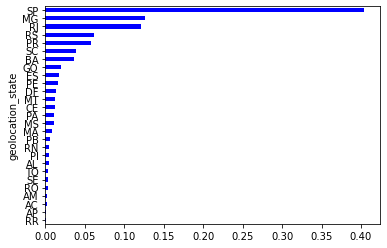

In [1]:
from olist_commons import get_geolocation, discrete_stats, plot_value_freqs
geolocation = get_geolocation()
display(discrete_stats(geolocation, 'geolocation'))
plot_value_freqs(geolocation, 'geolocation_state')

In [2]:
geolocation.columns = ['zip_code_prefix', 'lat', 'lng', 'city', 'state']
display(geolocation)

,zip_code_prefix,lat,lng,city,state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.64482,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS
1000159,99900,-27.877125,-52.224882,getulio vargas,RS
1000160,99950,-28.071855,-52.014716,tapejara,RS
1000161,99980,-28.388932,-51.846871,david canabarro,RS


Toutes les localisations :

Cela fait immédiatement ressortir la concentration d'abord sur l'Amérique latine, puis à l'international sur quelques zones de la sphère linguistique espagnole / portugais : à vérifier.

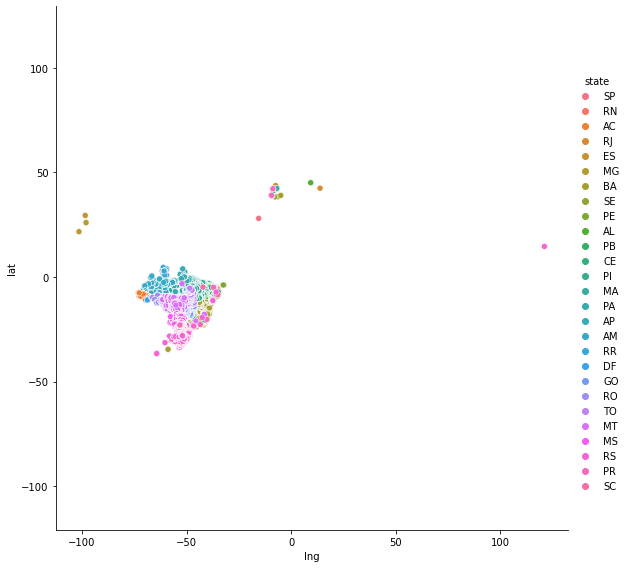

In [15]:
#import matplotlib.image as mpimg
#img = mpimg.imread('../img/seattle_map.png')
#f, ax = plt.subplots()
#plt.imshow(img, zorder=.5)
import matplotlib.pyplot as plt
import seaborn as sns
plot = sns.relplot(
    x='lng',
    y='lat',
    hue='state',
    data=geolocation,
    height=8)
#plot.axes[0, 0].imshow(img, alpha=.5, zorder=1)
plt.axis('equal')
plt.show()

Zoom sur l'Amérique Latine :

* https://en.wikipedia.org/wiki/Latin_America
* https://en.wikipedia.org/wiki/South_America
* https://en.wikipedia.org/wiki/Brazil
* https://en.wikipedia.org/wiki/Regions_of_Brazil
* https://en.wikipedia.org/wiki/Federative_units_of_Brazil

Direct scraping of https://en.wikipedia.org/wiki/Federative_units_of_Brazil#List

Certains points sot manisfestement mal classés : un kNN permettrait une détection et correction relativement sûre des anomalies.

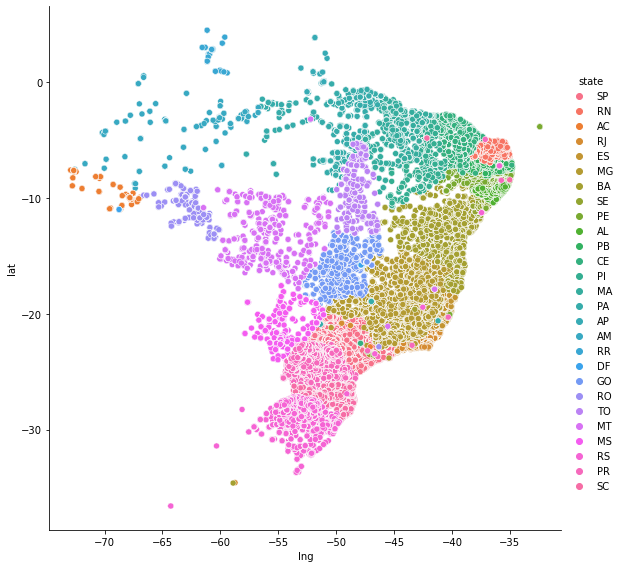

In [16]:
import seaborn as sns
from olist_commons import select_region
south_america = select_region(geolocation, (-75, -25), (-45, 10))
sns.relplot(x='lng', y='lat', hue='state', data=south_america, height=8)
plt.axis('equal')
plt.show()

Scraping

https://medium.com/analytics-vidhya/web-scraping-a-wikipedia-table-into-a-dataframe-c52617e1f451

In [18]:
from olist_commons import get_brazil_states
states = get_brazil_states()
display(states)

,Flag and name,Code,Capital,Largest city,Area(km2)[20],Population(2022)[21],"Density (perkm2, 2022)","GDP (R$millions, 2022)[22]",HDI(2022)[23]
0,Acre,AC,Rio Branco,Rio Branco,164123,892000,6.34,21000,0.719
1,Alagoas,AL,Maceió,Maceió,27779,3345000,125.52,73000,0.683
2,Amapá,AP,Macapá,Macapá,142829,845000,2.63,9000,0.740
3,Amazonas,AM,Manaus,Manaus,1559159,4156000,2.58,103000,0.733
4,Bahia,BA,Salvador,Salvador,564733,14942000,30.52,257000,0.714
5,Ceará,CE,Fortaleza,Fortaleza,148921,8870000,60.33,157000,0.735
6,Distrito Federal,DF,Brasília,Brasília,5780,3135000,493.00,249000,0.850
7,Espírito Santo,ES,Vitória,Serra,46095,3982000,80.63,125000,0.772
8,Goiás,GO,Goiânia,Goiânia,340112,7116000,18.46,202000,0.769
9,Maranhão,MA,São Luís,São Luís,331937,7134000,19.03,102000,0.687


Etiquettes complètes des états et classement par ordre décroissant de population

In [20]:
pop_col = states.columns[5]
states = states.sort_values(by=pop_col, ascending=False)
display(states)

,Flag and name,Code,Capital,Largest city,Area(km2)[20],Population(2022)[21],"Density (perkm2, 2022)","GDP (R$millions, 2022)[22]",HDI(2022)[23]
24,São Paulo,SP,São Paulo,São Paulo,248223,46004000,175.73,1964000,0.826
12,Minas Gerais,MG,Belo Horizonte,Belo Horizonte,586522,21212000,31.72,583000,0.787
18,Rio de Janeiro,RJ,Rio de Janeiro,Rio de Janeiro,43780,17309000,387.46,693000,0.796
4,Bahia,BA,Salvador,Salvador,564733,14942000,30.52,257000,0.714
15,Paraná,PR,Curitiba,Curitiba,199308,11515000,43.46,417000,0.792
20,Rio Grande do Sul,RS,Porto Alegre,Porto Alegre,281730,11407000,36.84,444000,0.787
16,Pernambuco,PE,Recife,Recife,98148,9599000,103.83,201000,0.727
5,Ceará,CE,Fortaleza,Fortaleza,148921,8870000,60.33,157000,0.735
13,Pará,PA,Belém,Belém,1247955,8623000,7.02,156000,0.698
23,Santa Catarina,SC,Florianópolis,Joinville,95736,7175000,69.74,293000,0.808


In [37]:
st = states[states.columns[0:2]]
dict_map = {list(r[1])[1]: list(r[1])[0] for r in st.iterrows()}
state_name = geolocation.state.map(dict_map).rename('state_name')
display(state_name)
display(state_name.value_counts())

0                  São Paulo
1                  São Paulo
2                  São Paulo
3                  São Paulo
4                  São Paulo
                 ...        
1000158    Rio Grande do Sul
1000159    Rio Grande do Sul
1000160    Rio Grande do Sul
1000161    Rio Grande do Sul
1000162    Rio Grande do Sul
Name: state_name, Length: 1000163, dtype: object

São Paulo              404268
Minas Gerais           126336
Rio de Janeiro         121169
Rio Grande do Sul       61851
Paraná                  57859
Santa Catarina          38328
Bahia                   36045
Goiás                   20139
Espírito Santo          16748
Pernambuco              16432
Distrito Federal        12986
Mato Grosso             12031
Ceará                   11674
Pará                    10853
Mato Grosso do Sul      10431
Maranhão                 7853
Paraíba                  5538
Rio Grande do Norte      5041
Piauí                    4549
Alagoas                  4183
Tocantins                3576
Sergipe                  3563
Rondônia                 3478
Amazonas                 2432
Acre                     1301
Amapá                     853
Roraima                   646
Name: state_name, dtype: int64

In [38]:
geolocation_stnames = pd.concat([geolocation, state_name], axis=1)
display(geolocation_stnames)

,zip_code_prefix,lat,lng,city,state,state_name
0,1037,-23.545621,-46.639292,sao paulo,SP,São Paulo
1,1046,-23.546081,-46.64482,sao paulo,SP,São Paulo
2,1046,-23.546129,-46.642951,sao paulo,SP,São Paulo
3,1041,-23.544392,-46.639499,sao paulo,SP,São Paulo
4,1035,-23.541578,-46.641607,sao paulo,SP,São Paulo
...,...,...,...,...,...,...
1000158,99950,-28.068639,-52.010705,tapejara,RS,Rio Grande do Sul
1000159,99900,-27.877125,-52.224882,getulio vargas,RS,Rio Grande do Sul
1000160,99950,-28.071855,-52.014716,tapejara,RS,Rio Grande do Sul
1000161,99980,-28.388932,-51.846871,david canabarro,RS,Rio Grande do Sul


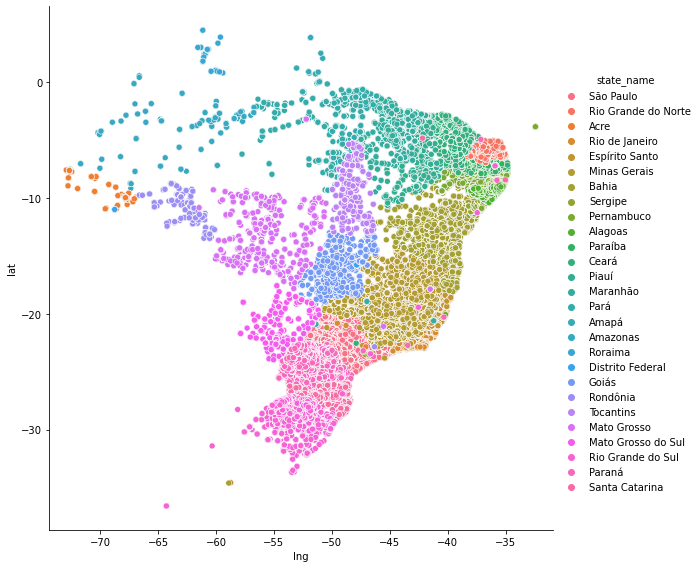

In [39]:
import seaborn as sns
from olist_commons import select_region
south_america = select_region(geolocation_stnames, (-75, -25), (-45, 10))
sns.relplot(x='lng', y='lat', hue='state_name', data=south_america, height=8)
plt.axis('equal')
plt.show()

Ventes hors Brésil

Le problème, c'est que les étiquettes correspondent bien à des états brésiliens.

Il s'agit donc soit :
* d'erreurs de géolocalisation : mauvaises coordonnées GPS
* d'erreurs consistant à donner un label d'état brésilien à défaut d'autre label disponible pour désigner d'autres régions du monde

Par exemple 513631	28165	41.614052	-8.411675	vila nova de campos	RJ

correspond à une localisation au portugal (Lago) : https://www.openstreetmap.org/#map=9/41.6141/-8.4117

On en déduit que la localité indiquée peut être découplée des coordonnées, probablement parce que la personne déclare son lieu de résidence (où recevoir la facture) au moment de son achat, mais que la coordonnées enregistrée est celle du lieu d'où est passée la commande. Dans la majorité des cas, cela coïncide, mais cela diverge pour les personnes en déplacement au moment de leur achat.

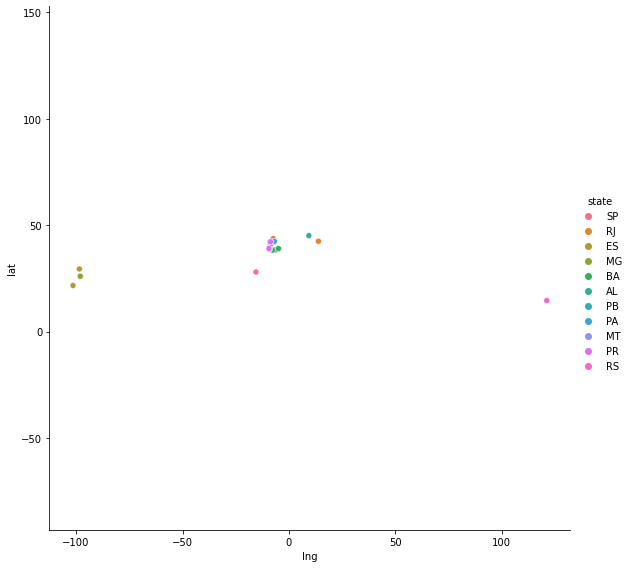

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from olist_commons import select_outof_region
outof_south_america = select_outof_region(geolocation, (-75, -25), (-45, 10))
sns.relplot(x='lng', y='lat', hue='state', data=outof_south_america, height=8)
plt.axis('equal')
plt.show()

In [7]:
display(outof_south_america)

,zip_code_prefix,lat,lng,city,state
387565,18243,28.008978,-15.536867,bom retiro da esperanca,SP
513631,28165,41.614052,-8.411675,vila nova de campos,RJ
513754,28155,42.439286,13.820214,santa maria,RJ
514429,28333,38.381672,-6.3282,raposo,RJ
516682,28595,43.684961,-7.41108,portela,RJ
538512,29654,29.409252,-98.484121,santo antônio do canaã,ES
538557,29654,21.657547,-101.466766,santo antonio do canaa,ES
585242,35179,25.995203,-98.078544,santana do paraíso,MG
585260,35179,25.995245,-98.078533,santana do paraiso,MG
695377,45936,38.323939,-6.775035,itabatan,BA


La connaissance des lieux de résidence, voire des quartiers peut conduire à des clusters pertinents dans la mesure, et c'est particulièrement vrai au Brésil, où les inégalités sont fortes, et où il y a une ségrégation territoriale forte des populations en fonction de leur catégorie CSP. A explorer donc plus avant, en commençant par des statistiques de CA, et de CA par client en fonction des territoires (donc des labels connus), avant de s'en remettre au clustering.

Au niveau du clustering, la géolocalisation nous semble une indication moins pertinente qu'un indicateur de type indice CSP territorial qui traduit la capacité économique des clients suivant leur territoire (applicables sur n niveaux de granulatité territoriale)

NEXT

Ciblage par ville, par pays, etc : granularités territoriales

Abstraction : simplement par arrondi des coordonnées => sns permet de représenter la densité de différentes manières

Le must serait d'en profiter pour reprendre mon investigation des librairies geodata

# A propos de PEP8 (*Python Enhancement Proposal*)

Doc:
* **PEP 8 — the Style Guide for Python Code** [https://pep8.org/](https://pep8.org/)
* ⇒ **PEP 8 – Style Guide for Python Code** [https://peps.python.org/pep-0008/](https://peps.python.org/pep-0008/)
* ✔ **How to Write Beautiful Python Code With PEP 8** [https://realpython.com/python-pep8/](https://realpython.com/python-pep8/)
* **Geeks 4 Geeks - Python – Conventions and PEP8** [https://www.geeksforgeeks.org/python-conventions-and-pep8/](https://www.geeksforgeeks.org/python-conventions-and-pep8/)
* [https://www.datacamp.com/tutorial/pep8-tutorial-python-code](https://www.datacamp.com/tutorial/pep8-tutorial-python-code)

Compl. :
* https://realpython.com/python-code-quality/
* https://realpython.com/documenting-python-code
    * https://realpython.com/documenting-python-code/#documenting-your-python-code-base-using-docstrings


Tools :
* **https://code.visualstudio.com/docs/python/linting



# Correction des données de géolocalisation

## Point rapide sur les données

### ✔ Rappel

In [1]:
from pepper_commons import discrete_stats
from olist_commons import (
    get_customer_orders,
    get_sellers,
    get_geolocations,
)
customer_orders = get_customer_orders()
sellers = get_sellers()
geolocations = get_geolocations()

In [2]:
display(discrete_stats(geolocations))

,n,n_u,n_na,fr,vr
geolocations,,,,,
lat,1000163,717372,0,1.0,0.717255
lng,1000163,717615,0,1.0,0.717498
zip_code_prefix,1000163,19015,0,1.0,0.019012
city,1000163,8011,0,1.0,0.008010
state,1000163,27,0,1.0,0.000027


In [3]:
display(discrete_stats(customer_orders))

,n,n_u,n_na,fr,vr
customers_orders,,,,,
customer_id,99441,96096,0,1.0,0.966362
zip_code_prefix,99441,14994,0,1.0,0.150783
city,99441,4119,0,1.0,0.041422
state,99441,27,0,1.0,0.000272


In [4]:
display(discrete_stats(sellers))

,n,n_u,n_na,fr,vr
sellers,,,,,
zip_code_prefix,3095,2246,0,1.0,0.725687
city,3095,611,0,1.0,0.197415
state,3095,23,0,1.0,0.007431


### Unicités

#### ✔ Triplets `(zip, city, state)` uniques

On observe que la table des géolocalisations, qui est la plus large, comporte environ deux fois plus de noms qu'il n'y a de municipalités au Brésil (8 011 contre 5 569).

La raison est que l'orthographie des noms n'a pas été normalisée. Elle varie notamment entre les version avec et sans diacritiques.

In [5]:
from olist_commons import get_zcs_reduction

In [6]:
geolocations_zcs = get_zcs_reduction(geolocations)
display(discrete_stats(geolocations_zcs))

,n,n_u,n_na,fr,vr
geolocations,,,,,
zip_code_prefix,27912,19015,0,1.0,0.681248
city,27912,8011,0,1.0,0.287009
state,27912,27,0,1.0,0.000967


In [7]:
customer_orders_zcs = get_zcs_reduction(customer_orders)
display(discrete_stats(customer_orders_zcs))

,n,n_u,n_na,fr,vr
customers_orders,,,,,
zip_code_prefix,15034,14994,0,1.0,0.997339
city,15034,4119,0,1.0,0.273979
state,15034,27,0,1.0,0.001796


In [8]:
sellers_zcs = get_zcs_reduction(sellers)
display(discrete_stats(sellers_zcs))

,n,n_u,n_na,fr,vr
sellers,,,,,
zip_code_prefix,2296,2246,0,1.0,0.978223
city,2296,611,0,1.0,0.266115
state,2296,23,0,1.0,0.010017


### ✔ Un code est-il associé à une municipalité et un état unique ?

Non !

In [9]:
gpby = geolocations_zcs.groupby(by='zip_code_prefix').agg(['count', list])
display(gpby)

geolocations     city                         state          
                count                    list count      list
zip_code_prefix                                              
01001               2  [sao paulo, são paulo]     2  [SP, SP]
01002               2  [sao paulo, são paulo]     2  [SP, SP]
01003               2  [sao paulo, são paulo]     2  [SP, SP]
01004               2  [sao paulo, são paulo]     2  [SP, SP]
01005               2  [sao paulo, são paulo]     2  [SP, SP]
...               ...                     ...   ...       ...
99960               1               [charrua]     1      [RS]
99965               1            [agua santa]     1      [RS]
99970               2      [ciriaco, ciríaco]     2  [RS, RS]
99980               1       [david canabarro]     1      [RS]
99990               1             [muliterno]     1      [RS]

[19015 rows x 4 columns]

In [10]:
display(gpby[gpby[('city', 'count')] > 4])
display(gpby[gpby[('city', 'count')] > 1])

geolocations     city                                                     \
                count                                               list   
zip_code_prefix                                                            
06900               5  [embu-guacu, embu-guaçu, embu guaçu, embu guac...   
13318               5  [jacare, cabreuva, jacaré, jacaré (cabreúva), ...   
13454               5  [santa barbara d'oeste, santa bárbara d'oeste,...   
13455               5  [santa barbara d'oeste, santa barbara d oeste,...   
13457               5  [santa bárbara d'oeste, santa barbara d oeste,...   
17970               5  [sao joao do pau d'alho, são joão do pau d'alh...   
28950               5  [armacao dos buzios, armação dos búzios, armac...   
42850               5  [dias d'avila, dias d'ávila, dias davila, dias...   
78290               5  [figueiropolis d'oeste, figueiropolis d oeste,...   

geolocations    state                        
                count                  list  
zip_code_prefix                              
06900               5  [SP, SP, SP, SP, SP]  
13318               5  [SP, SP, SP, SP, SP]  
13454               5  [SP, SP, SP, SP, SP]  
13455               5  [SP, SP, SP, SP, SP]  
13457               5  [SP, SP, SP, SP, SP]  
17970               5  [SP, SP, SP, SP, SP]  
28950               5  [RJ, RJ, RJ, RJ, RJ]  
42850               5  [BA, BA, BA, BA, BA]  
78290               5  [MT, MT, MT, MT, MT]

geolocations     city                                   state          
                count                              list count      list
zip_code_prefix                                                        
01001               2            [sao paulo, são paulo]     2  [SP, SP]
01002               2            [sao paulo, são paulo]     2  [SP, SP]
01003               2            [sao paulo, são paulo]     2  [SP, SP]
01004               2            [sao paulo, são paulo]     2  [SP, SP]
01005               2            [sao paulo, são paulo]     2  [SP, SP]
...               ...                               ...   ...       ...
99900               2  [getulio vargas, getúlio vargas]     2  [RS, RS]
99930               2                [estacao, estação]     2  [RS, RS]
99940               2                  [ibiaca, ibiaçá]     2  [RS, RS]
99955               2      [vila langaro, vila lângaro]     2  [RS, RS]
99970               2                [ciriaco, ciríaco]     2  [RS, RS]

[8559 rows x 4 columns]

### Normalisation des noms des municipalités

In [11]:
from olist_commons import scrap_brazil_municipalities, get_municipalities #_pk : sinon ambigü
state_municipalities = scrap_brazil_municipalities() #get_municipalities()
display(state_municipalities)

,Region,State,CO,Mesoregion,Microregion,Municipality,is_state_capital
0,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Assis Brasil,False
1,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Brasiléia,False
2,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Epitaciolândia,False
3,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Xapuri,False
4,Northern Brazil,Acre,AC,Vale do Acre,Rio Branco,Acrelândia,False
...,...,...,...,...,...,...,...
5564,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Salete,False
5565,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Taió,False
5566,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Trombudo Central,False
5567,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Vitor Meireles,False


In [12]:
display(state_municipalities[state_municipalities.is_state_capital])

,Region,State,CO,Mesoregion,Microregion,Municipality,is_state_capital
9,Northern Brazil,Acre,AC,Vale do Acre,Rio Branco,Rio Branco,True
30,Northern Brazil,Amapá,AP,Sul do Amapá,Macapá,Macapá,True
55,Northern Brazil,Amazonas,AM,Centro Amazonense,Manaus,Manaus,True
133,Northern Brazil,Pará,PA,Metropolitana de Belém,Belém,Belém,True
295,Northern Brazil,Rondônia,RO,Madeira-Guapore,Porto Velho,Porto Velho,True
298,Northern Brazil,Roraima,RR,Norte de Roraima,Boa Vista,Boa Vista,True
444,Northern Brazil,Tocantins,TO,Oriental do Tocantins,Porto Nacional,Palmas,True
483,Northeastern Brazil,Alagoas,AL,Leste Alagoano,Maceió,Maceió,True
787,Northeastern Brazil,Bahia,BA,Centro Norte Baiano,Salvador,Salvador,True
1007,Northeastern Brazil,Ceará,CE,Metropolitana de Fortaleza,Fortaleza,Fortaleza,True


Algorithme :
* pour chaque nom de la base (geolocations, customers, sellers), on forme une clé en :
    * passant aux minuscules
    * supprimant les diacritiques
    * en remplaçant les ponctuations ('-', "'", etc) par '_'
    * en préfixant du code 2a de l'état
* idem pour la base des noms officiels (réduite aux seuls noms de municipalité uniques, indépendamment de l'état)
* on complète à gauche la base (geolocations, customers, sellers) avec celle des noms officiels
* on en déduit les noms normalisés
* on en dérive la liste (idéalement vide) des municipalités qui ne font pas partie des noms officiels

In [13]:
from olist_commons import remove_accents
def add_city_key(data, st_code_label, city_label):
    data.insert(
        0, 'key',
        data[st_code_label].str.lower() + '_' + (
            data[city_label]
            .str.lower()
            .apply(remove_accents)
            .str.replace(r"[ -']", '_', regex=True)
        )
    )

In [14]:
sm = state_municipalities.copy()
add_city_key(sm, 'CO', 'Municipality')
display(sm)

,key,Region,State,CO,Mesoregion,Microregion,Municipality,is_state_capital
0,ac_assis_brasil,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Assis Brasil,False
1,ac_brasileia,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Brasiléia,False
2,ac_epitaciolandia,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Epitaciolândia,False
3,ac_xapuri,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Xapuri,False
4,ac_acrelandia,Northern Brazil,Acre,AC,Vale do Acre,Rio Branco,Acrelândia,False
...,...,...,...,...,...,...,...,...
5564,sc_salete,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Salete,False
5565,sc_taio,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Taió,False
5566,sc_trombudo_central,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Trombudo Central,False
5567,sc_vitor_meireles,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Vitor Meireles,False


In [15]:
display(sm[sm.key == 'sp_sao_paulo'])

,key,Region,State,CO,Mesoregion,Microregion,Municipality,is_state_capital
4083,sp_sao_paulo,Southeastern Brazil,São Paulo,SP,Metropolitana de São Paulo,São Paulo,São Paulo,True


In [16]:
official_cities = state_municipalities[['CO', 'Municipality']].drop_duplicates().reset_index(drop=True)
add_city_key(official_cities, 'CO', 'Municipality')
display(official_cities)

,key,CO,Municipality
0,ac_assis_brasil,AC,Assis Brasil
1,ac_brasileia,AC,Brasiléia
2,ac_epitaciolandia,AC,Epitaciolândia
3,ac_xapuri,AC,Xapuri
4,ac_acrelandia,AC,Acrelândia
...,...,...,...
5564,sc_salete,SC,Salete
5565,sc_taio,SC,Taió
5566,sc_trombudo_central,SC,Trombudo Central
5567,sc_vitor_meireles,SC,Vitor Meireles


In [17]:
display(official_cities[official_cities.key.str.startswith('rs_bu')])

,key,CO,Municipality
4953,rs_butia,RS,Butiá


In [18]:
display(official_cities[official_cities.key.str.endswith('riti')])

,key,CO,Municipality
1130,ce_mauriti,CE,Mauriti
1223,ma_buriti,MA,Buriti
1987,pi_canto_do_buriti,PI,Canto do Buriti
2666,ms_dois_irmaos_do_buriti,MS,Dois Irmãos do Buriti
3686,rj_sao_joao_de_meriti,RJ,São João de Meriti


In [19]:
vc = official_cities.key.value_counts()
display(vc)

ac_assis_brasil                  1
rj_campos_dos_goytacazes         1
rj_quissama                      1
rj_macae                         1
rj_conceicao_de_macabu           1
                                ..
pi_nossa_senhora_dos_remedios    1
pi_morro_do_chapeu_do_piaui      1
pi_miguel_alves                  1
pi_matias_olimpio                1
sc_witmarsum                     1
Name: key, Length: 5569, dtype: int64

In [20]:
gzcs = geolocations_zcs.copy()
add_city_key(gzcs, 'state', 'city')
display(gzcs)

geolocations,key,zip_code_prefix,city,state
0,sp_sao_paulo,01037,sao paulo,SP
1,sp_sao_paulo,01046,sao paulo,SP
2,sp_sao_paulo,01041,sao paulo,SP
3,sp_sao_paulo,01035,sao paulo,SP
4,sp_sao_paulo,01012,são paulo,SP
...,...,...,...,...
27907,rs_ibiaca,99940,ibiaçá,RS
27908,rs_santa_cecilia_do_sul,99952,santa cecilia do sul,RS
27909,rs_ciriaco,99970,ciríaco,RS
27910,rs_estacao,99930,estação,RS


In [21]:
import pandas as pd
fixed_gzcs = pd.merge(gzcs, official_cities, how='left', on='key')
display(fixed_gzcs)

,key,zip_code_prefix,city,state,CO,Municipality
0,sp_sao_paulo,01037,sao paulo,SP,SP,São Paulo
1,sp_sao_paulo,01046,sao paulo,SP,SP,São Paulo
2,sp_sao_paulo,01041,sao paulo,SP,SP,São Paulo
3,sp_sao_paulo,01035,sao paulo,SP,SP,São Paulo
4,sp_sao_paulo,01012,são paulo,SP,SP,São Paulo
...,...,...,...,...,...,...
27907,rs_ibiaca,99940,ibiaçá,RS,RS,Ibiaçá
27908,rs_santa_cecilia_do_sul,99952,santa cecilia do sul,RS,RS,Santa Cecília do Sul
27909,rs_ciriaco,99970,ciríaco,RS,RS,Ciríaco
27910,rs_estacao,99930,estação,RS,RS,Estação


In [22]:
display(discrete_stats(fixed_gzcs))
display(fixed_gzcs[fixed_gzcs.CO.isna()])

,n,n_u,n_na,fr,vr
key,27912,6331,0,1.000000,0.226820
zip_code_prefix,27912,19015,0,1.000000,0.681248
city,27912,8011,0,1.000000,0.287009
state,27912,27,0,1.000000,0.000967
CO,26591,27,1321,0.952673,0.001015
Municipality,26591,5197,1321,0.952673,0.195442


,key,zip_code_prefix,city,state,CO,Municipality
812,rn_sao_paulo,02116,são paulo,RN,NaN,NaN
3382,ac_sao_paulo,04011,sao paulo,AC,NaN,NaN
3563,sp_saopaulo,04132,sãopaulo,SP,NaN,NaN
3873,sp_sp,04346,sp,SP,NaN,NaN
4462,sp_saPSo_paulo,04728,sa£o paulo,SP,NaN,NaN
...,...,...,...,...,...,...
27527,rs_sant_ana_do_livramento,97578,sant'ana do livramento,RS,NaN,NaN
27532,rs_barrado_quarai,97538,barrado quarai,RS,NaN,NaN
27533,rs_sant_ana_do_livramento,97573,sant'ana do livramento,RS,NaN,NaN
27667,rs_padre_gonzales,98620,padre gonzales,RS,NaN,NaN


In [23]:
from olist_commons import load_brazil_zip_codes
zips = load_brazil_zip_codes()
add_city_key(zips, 'admin_code1', 'place_name')
display(zips)

,key,postal_code,place_name,admin name1,admin_code1,admin code2,latitude,longitude
0,01_acrelandia,69945-000,Acrelândia,Acre,01,1200013,-9.9805,-66.8439
1,01_assis_brasil,69935-000,Assis Brasil,Acre,01,1200054,-10.8833,-70.0131
2,01_brasileia,69932-000,Brasiléia,Acre,01,1200104,-10.7677,-69.0114
3,01_bujari,69923-000,Bujari,Acre,01,1200138,-9.5786,-68.172
4,01_capixaba,69922-000,Capixaba,Acre,01,1200179,-10.4878,-67.8483
...,...,...,...,...,...,...,...,...
5520,31_tupirama,77704-000,Tupirama,Tocantins,31,1721257,-8.9192,-48.2766
5521,31_tupiratins,77743-000,Tupiratins,Tocantins,31,1721307,-8.3858,-48.223
5522,31_wanderlandia,77860-000,Wanderlândia,Tocantins,31,1722081,-6.798,-48.0041
5523,31_xambioa,77880-000,Xambioá,Tocantins,31,1722107,-6.5941,-48.4314


In [24]:
display(zips[zips.key.str.endswith('gonzales')])

,key,postal_code,place_name,admin name1,admin_code1,admin code2,latitude,longitude
3740,23_roque_gonzales,97970-000,Roque Gonzales,Rio Grande do Sul,23,4316303,-28.0567,-55.1205


In [25]:
display(zips[zips.postal_code.str.startswith('584')])

,key,postal_code,place_name,admin name1,admin_code1,admin code2,latitude,longitude
2317,17_alcantil,58460-000,Alcantil,Paraiba,17,2500536,-7.6982,-36.066
2329,17_aroeiras,58400-000,Aroeiras,Paraiba,17,2501302,-7.5206,-35.6993
2334,17_barra_de_santana,58458-000,Barra de Santana,Paraiba,17,2501575,-7.5905,-35.9882
2336,17_barra_de_sao_miguel,58470-000,Barra de São Miguel,Paraiba,17,2501708,-7.7164,-36.2548
2346,17_boqueirao,58450-000,Boqueirão,Paraiba,17,2502508,-7.5506,-36.1298
2352,17_cabaceiras,58480-000,Cabaceiras,Paraiba,17,2503100,-7.5086,-36.3335
2370,17_caturite,58455-000,Caturité,Paraiba,17,2504355,-7.4199,-36.0419
2392,17_fagundes,58430-000,Fagundes,Paraiba,17,2506103,-7.3916,-35.7742
2394,17_gado_bravo,58405-000,Gado Bravo,Paraiba,17,2506251,-7.5998,-35.8197
2437,17_natuba,58410-000,Natuba,Paraiba,17,2509909,-7.5581,-35.5463


## Scraping de la table des municipalités

https://en.wikipedia.org/wiki/List_of_municipalities_of_Brazil

### Liste des municipalités brésiliennes sur Wikipedia

Il y a **5 569** municipalités.

In [25]:
from olist_commons import scrap_brazil_municipalities
municipalities = scrap_brazil_municipalities()
display(municipalities)

,Region,State,CO,Mesoregion,Microregion,Municipality,is_state_capital
0,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Assis Brasil,False
1,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Brasiléia,False
2,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Epitaciolândia,False
3,Northern Brazil,Acre,AC,Vale do Acre,Brasiléia,Xapuri,False
4,Northern Brazil,Acre,AC,Vale do Acre,Rio Branco,Acrelândia,False
...,...,...,...,...,...,...,...
5564,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Salete,False
5565,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Taió,False
5566,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Trombudo Central,False
5567,Southern Brazil,Santa Catarina,SC,Vale do Itajaí,Rio do Sul,Vitor Meireles,False


Certaines municipalités ont le même nom, mais plusieurs deux états différents.

230 noms homonymes désignent ainsi jusqu'à 5 municipalités distinctes (par exemple 'Bom Jesus' (PB, PI, RN, RS, SC) et São Domingos	(BA, GO, PB, SC, SE)).

En revanche, au sein d'un état, il n'y a pas de municipalités homonymes.

Conclusion : le couple `(State, Municipality)` est une clé primaire (mais pas `Municipality`).

In [26]:
from pepper_commons import discrete_stats
display(discrete_stats(municipalities))

,n,n_u,n_na,fr,vr
Region,5569,5,0,1.0,0.000898
State,5569,27,0,1.0,0.004848
CO,5569,27,0,1.0,0.004848
Mesoregion,5569,137,0,1.0,0.024600
Microregion,5569,554,0,1.0,0.099479
Municipality,5569,5295,0,1.0,0.950799
is_state_capital,5569,2,0,1.0,0.000359


In [27]:
from olist_commons import get_municipalities #_pk : sinon ambigü
state_municipalities = get_municipalities(municipalities)
display(state_municipalities)

,CO,Municipality
0,AC,Assis Brasil
1,AC,Tarauacá
2,AC,Jordão
3,AC,Feijó
4,AC,Rodrigues Alves
...,...,...
5564,TO,Crixás do Tocantins
5565,TO,Figueirópolis
5566,TO,Gurupi
5567,TO,Aliança do Tocantins


In [28]:
duplicates = state_municipalities.groupby(by='Municipality').agg([list, 'count'])
display(duplicates[duplicates[('CO', 'count')] > 4])
display(duplicates[duplicates[('CO', 'count')] > 1])

CO      
                              list count
Municipality                            
Bom Jesus     [PB, PI, RN, RS, SC]     5
São Domingos  [BA, GO, PB, SC, SE]     5

CO      
                        list count
Municipality                      
Alagoinha           [PB, PE]     2
Alto Alegre     [RR, RS, SP]     3
Alto Paraíso        [PR, RO]     2
Alvorada            [RS, TO]     2
Amparo              [PB, SP]     2
...                      ...   ...
Várzea              [PB, RN]     2
Várzea Grande       [MT, PI]     2
Wenceslau Braz      [MG, PR]     2
Água Boa            [MG, MT]     2
Água Branca     [AL, PB, PI]     3

[234 rows x 2 columns]

In [29]:
from olist_commons import get_municipality_states
municipalities_states = get_municipality_states(municipalities)
display(municipalities_states)

,2A,Stãte,State
0,AC,Acre,Acre
1,AL,Alagoas,Alagoas
2,AM,Amazonas,Amazonas
3,AP,Amapá,Amapa
4,BA,Bahia,Bahia
5,CE,Ceará,Ceara
6,DF,Distrito Federal,Distrito Federal
7,ES,Espírito Santo,Espirito Santo
8,GO,Goiás,Goias
9,MA,Maranhão,Maranhao


### Liste des codes postaux (Geonames.org)

Il y a **5 525** codes postaux, donc 44 de moins que de municipalités.

In [30]:
from olist_commons import load_brazil_zip_codes
zips = load_brazil_zip_codes()
display(zips)

,postal_code,place_name,admin name1,admin_code1,admin code2,latitude,longitude
0,69945-000,Acrelândia,Acre,01,1200013,-9.9805,-66.8439
1,69935-000,Assis Brasil,Acre,01,1200054,-10.8833,-70.0131
2,69932-000,Brasiléia,Acre,01,1200104,-10.7677,-69.0114
3,69923-000,Bujari,Acre,01,1200138,-9.5786,-68.172
4,69922-000,Capixaba,Acre,01,1200179,-10.4878,-67.8483
...,...,...,...,...,...,...,...
5520,77704-000,Tupirama,Tocantins,31,1721257,-8.9192,-48.2766
5521,77743-000,Tupiratins,Tocantins,31,1721307,-8.3858,-48.223
5522,77860-000,Wanderlândia,Tocantins,31,1722081,-6.798,-48.0041
5523,77880-000,Xambioá,Tocantins,31,1722107,-6.5941,-48.4314


In [31]:
from pepper_commons import discrete_stats
display(discrete_stats(zips))

,n,n_u,n_na,fr,vr
postal_code,5525,5525,0,1.00000,1.000000
place_name,5525,5250,0,1.00000,0.950226
admin name1,5525,27,0,1.00000,0.004887
admin_code1,5525,27,0,1.00000,0.004887
admin code2,5495,5495,30,0.99457,1.000000
latitude,5525,5460,0,1.00000,0.988235
longitude,5525,5449,0,1.00000,0.986244


Séparation des parties préfixe et suffixe

In [32]:
display(len(zips.postal_code.str[:-4].unique()))

5519

In [33]:
display(zips.postal_code.str[-3:].unique())

array(['000', '500', '800'], dtype=object)

In [34]:
display(zips[zips.place_name == 'Brasília'])

,postal_code,place_name,admin name1,admin_code1,admin code2,latitude,longitude
800,70000-000,Brasília,Distrito Federal,07,5300108,-15.8307,-47.6127


### Liste des codes postaux (Github Datasets-BR)

https://github.com/datasets-br/city-codes/blob/master/data/br-city-codes.csv

#### Chargement de la table

In [35]:
from olist_commons import load_brazil_zip_codes_compl
from pepper_commons import discrete_stats
zip_compls = load_brazil_zip_codes_compl()
display(discrete_stats(zip_compls))
display(zip_compls)

,n,n_u,n_na,fr,vr
zip_codes_compl,,,,,
name,5573,5297,0,1.0000,0.950476
state,5573,27,0,1.0000,0.004845
wdId,5573,5570,0,1.0000,0.999462
idIBGE,5573,5570,0,1.0000,0.999462
lexLabel,5573,5289,0,1.0000,0.949040
postalCode_ranges,5573,5573,0,1.0000,1.000000
ddd,5573,67,0,1.0000,0.012022
abbrev3,4508,4170,1065,0.8089,0.925022


zip_codes_compl,name,state,wdId,idIBGE,lexLabel,postalCode_ranges,ddd,abbrev3
0,Abadia de Goiás,GO,Q304652,5200050,abadia.goias,"(75345-000, 75349-999)",62,NaN
1,Abadia dos Dourados,MG,Q582223,3100104,abadia.dourados,"(38540-000, 38549-999)",34,ABD
2,Abadiânia,GO,Q304716,5200100,abadiania,"(72940-000, 72959-999)",62,ABI
3,Abaeté,MG,Q1615444,3100203,abaete,"(35620-000, 35620-999)",37,AET
4,Abaetetuba,PA,Q1615298,1500107,abaetetuba,"(68440-000, 68444-999)",91,ABT
...,...,...,...,...,...,...,...,...
5565,Xique-Xique,BA,Q1762114,2933604,xique.xique,"(47400-000, 47439-999)",74,XXQ
5566,Zabelê,PB,Q1808686,2517407,zabele,"(58515-000, 58519-999)",83,NaN
5567,Zacarias,SP,Q1760645,3557154,zacarias,"(15265-000, 15269-999)",18,ZAC
5568,Zé Doca,MA,Q1806488,2114007,ze.doca,"(65365-000, 65367-999)",98,ZED


In [36]:
from olist_commons import get_zip_ranges_table
zip_ranges_table = get_zip_ranges_table()
display(zip_ranges_table)

,range_from,range_to,name,state
4853,01000,05999,São Paulo,SP
3468,06000,06299,Osasco,SP
1098,06300,06399,Carapicuíba,SP
557,06400,06499,Barueri,SP
4502,06500,06549,Santana de Parnaíba,SP
...,...,...,...,...
1258,99960,99964,Charrua,RS
61,99965,99969,Água Santa,RS
1279,99970,99979,Ciríaco,RS
1533,99980,99989,David Canabarro,RS


In [37]:
# srogneugneu ! Piège. Il fallait le voir ça... => détection systématique
display(zip_compls[zip_compls.name == 'Brasília'])
display(zip_compls[zip_compls.name == 'São Paulo'])
display(zip_compls[zip_compls.name == 'Nova Iguaçu'])
display(zip_compls[zip_compls.name == 'Santa Rosa'])
display(zip_ranges_table.loc[755])

zip_codes_compl,name,state,wdId,idIBGE,lexLabel,postalCode_ranges,ddd,abbrev3
755,Brasília,DF,Q2844,5300108,brasilia,"(70000-001, 72799-999)",61,BSA
755,Brasília,DF,Q2844,5300108,brasilia,"(73000-001, 73699-999)",61,BSA


zip_codes_compl,name,state,wdId,idIBGE,lexLabel,postalCode_ranges,ddd,abbrev3
4853,São Paulo,SP,Q174,3550308,sao.paulo,"(01000-001, 05999-999)",11,SPA
4853,São Paulo,SP,Q174,3550308,sao.paulo,"(08000-000, 08499-999)",11,SPA


zip_codes_compl,name,state,wdId,idIBGE,lexLabel,postalCode_ranges,ddd,abbrev3
3331,Nova Iguaçu,RJ,Q188897,3303500,nova.iguacu,"(26000-001, 26099-999)",21,NIU
3331,Nova Iguaçu,RJ,Q188897,3303500,nova.iguacu,"(26200-000, 26299-999)",21,NIU


zip_codes_compl,name,state,wdId,idIBGE,lexLabel,postalCode_ranges,ddd,abbrev3
4467,Santa Rosa,RS,Q995326,4317202,santa.rosa,"(98780-001, 98799-999)",55,SRO


,range_from,range_to,name,state
755,70000,72799,Brasília,DF
755,73000,73699,Brasília,DF


#### Résolution du nom cf. le code postal

In [38]:
display(geolocations_zcs)

geolocations,zip_code_prefix,city,state
0,01037,sao paulo,SP
1,01046,sao paulo,SP
2,01041,sao paulo,SP
3,01035,sao paulo,SP
4,01012,são paulo,SP
...,...,...,...
27907,99940,ibiaçá,RS
27908,99952,santa cecilia do sul,RS
27909,99970,ciríaco,RS
27910,99930,estação,RS


In [39]:
from olist_commons import get_names
names = get_names(geolocations_zcs.zip_code_prefix, zip_ranges_table)
display(names)

0                   São Paulo
1                   São Paulo
2                   São Paulo
3                   São Paulo
4                   São Paulo
                 ...         
27907                  Ibiaçá
27908    Santa Cecília do Sul
27909                 Ciríaco
27910                 Estação
27911            Vila Lângaro
Name: names, Length: 27912, dtype: object

#### Trous dans les blocs de codes postaux

In [40]:
from olist_commons import get_zip_ranges_holes_table
gap_merged_short = get_zip_ranges_holes_table() #ranges=None)
display(gap_merged_short)

,from,to,state,before_name,after_name
0,10000,10999,SP,Diadema,Santos
1,28700,28734,RJ,Cachoeiras de Macacu,Quissamã
2,32500,32599,MG,Mário Campos,Betim
3,32700,32899,MG,Betim,Igarapé
4,34020,34299,MG,Nova Lima,Rio Acima
5,36836,36839,MG,Caparaó,Faria Lemos
6,37549,37549,MG,Conceição dos Ouros,Pouso Alegre
7,38820,38839,MG,Rio Paranaíba,Carmo do Paranaíba
8,39220,39229,MG,Augusto de Lima,Buenópolis
9,39998,39999,MG_BA,Divisa Alegre,Salvador


#### hack pour utiliser get_name sur les cas irrésolus (ci-après)

In [41]:
# hack pour utiliser get_names sur les cas irrésolus
from olist_commons import get_zip_gap_ranges
gap_ranges = get_zip_gap_ranges(gap_merged_short)
display(gap_ranges)

,range_from,range_to,name
0,10000,10999,"(SP, Diadema, Santos)"
1,28700,28734,"(RJ, Cachoeiras de Macacu, Quissamã)"
2,32500,32599,"(MG, Mário Campos, Betim)"
3,32700,32899,"(MG, Betim, Igarapé)"
4,34020,34299,"(MG, Nova Lima, Rio Acima)"
5,36836,36839,"(MG, Caparaó, Faria Lemos)"
6,37549,37549,"(MG, Conceição dos Ouros, Pouso Alegre)"
7,38820,38839,"(MG, Rio Paranaíba, Carmo do Paranaíba)"
8,39220,39229,"(MG, Augusto de Lima, Buenópolis)"
9,39998,39999,"(MG_BA, Divisa Alegre, Salvador)"


### Corrections

#### Geolocations locations

In [51]:
from olist_commons import normalize_city_names

geolocations = get_geolocations()
display(discrete_stats(geolocations))

geolocations_normalized = normalize_city_names(geolocations)
display(discrete_stats(geolocations_normalized))

,n,n_u,n_na,fr,vr
geolocations,,,,,
lat,1000163,717372,0,1.0,0.717255
lng,1000163,717615,0,1.0,0.717498
zip_code_prefix,1000163,19015,0,1.0,0.019012
city,1000163,8011,0,1.0,0.008010
state,1000163,27,0,1.0,0.000027


,n,n_u,n_na,fr,vr
geolocations,,,,,
lat,1000163,717372,0,1.0,0.717255
lng,1000163,717615,0,1.0,0.717498
zip_code_prefix,1000163,19015,0,1.0,0.019012
city,1000163,5228,0,1.0,0.005227
state,1000163,27,0,1.0,0.000027


In [42]:
from olist_commons import get_names
g_zcs = geolocations_zcs.copy()
g_zcs['municipality'] = get_names(g_zcs.zip_code_prefix, zip_ranges_table)
display(g_zcs)

geolocations,zip_code_prefix,city,state,municipality
0,01037,sao paulo,SP,São Paulo
1,01046,sao paulo,SP,São Paulo
2,01041,sao paulo,SP,São Paulo
3,01035,sao paulo,SP,São Paulo
4,01012,são paulo,SP,São Paulo
...,...,...,...,...
27907,99940,ibiaçá,RS,Ibiaçá
27908,99952,santa cecilia do sul,RS,Santa Cecília do Sul
27909,99970,ciríaco,RS,Ciríaco
27910,99930,estação,RS,Estação


In [43]:
display(g_zcs[g_zcs.municipality.isna()])

geolocations,zip_code_prefix,city,state,municipality
13273,32553,betim,MG,NaN
15057,39220,augusto de lima,MG,NaN
15375,39999,aguas vermelhas,MG,NaN
18011,58310,cabedelo,PB,NaN
20665,69470,tefe,AM,NaN
23032,76370,pilar de goias,GO,NaN
24116,79878,vila vargas,MS,NaN
24145,79862,sao pedro,MS,NaN
24147,79864,itahum,MS,NaN
27714,98900,santa rosa,RS,NaN


In [44]:
unresolved_g_zcs = g_zcs[g_zcs.municipality.isna()]
unresolved_g_zcs = unresolved_g_zcs.drop(columns='municipality')
unresolved_g_zcs['municipality'] = get_names(
    unresolved_g_zcs.zip_code_prefix,
    gap_ranges
)
display(unresolved_g_zcs)

geolocations,zip_code_prefix,city,state,municipality
13273,32553,betim,MG,"(MG, Mário Campos, Betim)"
15057,39220,augusto de lima,MG,"(MG, Augusto de Lima, Buenópolis)"
15375,39999,aguas vermelhas,MG,"(MG_BA, Divisa Alegre, Salvador)"
18011,58310,cabedelo,PB,"(PB, Bayeux, Lucena)"
20665,69470,tefe,AM,"(AM, Coari, Tapauá)"
23032,76370,pilar de goias,GO,"(GO, São Luiz do Norte, Pilar de Goiás)"
24116,79878,vila vargas,MS,"(MS, Dourados, Douradina)"
24145,79862,sao pedro,MS,"(MS, Dourados, Douradina)"
24147,79864,itahum,MS,"(MS, Dourados, Douradina)"
27714,98900,santa rosa,RS,"(RS, Ubiretama, Alegria)"


#### Customer orders locations

In [45]:
from olist_commons import get_names
co_zcs = customer_orders_zcs.copy()
co_zcs['municipality'] = get_names(co_zcs.zip_code_prefix, zip_ranges_table)
display(co_zcs)

customers_orders,zip_code_prefix,city,state,municipality
0,14409,franca,SP,Franca
1,09790,sao bernardo do campo,SP,São Bernardo do Campo
2,01151,sao paulo,SP,São Paulo
3,08775,mogi das cruzes,SP,Mogi das Cruzes
4,13056,campinas,SP,Campinas
...,...,...,...,...
15029,87145,paicandu,PR,Paiçandu
15030,98860,eugenio de castro,RS,Eugênio de Castro
15031,05538,sao paulo,SP,São Paulo
15032,74980,aparecida de goiania,GO,Aparecida de Goiânia


In [46]:
display(co_zcs[co_zcs.municipality.isna()])

customers_orders,zip_code_prefix,city,state,municipality
7997,98900,santa rosa,RS,NaN


In [47]:
unresolved_co_zcs = co_zcs[co_zcs.municipality.isna()]
unresolved_co_zcs = unresolved_co_zcs.drop(columns='municipality')
unresolved_co_zcs['municipality'] = get_names(
    unresolved_co_zcs.zip_code_prefix,
    gap_ranges
)
unresolved_co_zcs.municipality = (
    unresolved_co_zcs.city.str.title()
    + '@'
    + unresolved_co_zcs.municipality.apply(
        lambda x: '[' + x[1] + '(' + x[0] + ')' + x[2] + ']'
    )
)
display(unresolved_co_zcs)
#display(norm_name)

customers_orders,zip_code_prefix,city,state,municipality
7997,98900,santa rosa,RS,Santa Rosa@[Ubiretama(RS)Alegria]


In [49]:
from olist_commons import normalize_city_names

customer_orders = get_customer_orders()
display(discrete_stats(customer_orders))

customer_orders_normalized = normalize_city_names(customer_orders)
display(discrete_stats(customer_orders_normalized))

,n,n_u,n_na,fr,vr
customers_orders,,,,,
customer_id,99441,96096,0,1.0,0.966362
zip_code_prefix,99441,14994,0,1.0,0.150783
city,99441,4119,0,1.0,0.041422
state,99441,27,0,1.0,0.000272


,n,n_u,n_na,fr,vr
customers_orders,,,,,
customer_id,99441,96096,0,1.0,0.966362
zip_code_prefix,99441,14994,0,1.0,0.150783
city,99441,3892,0,1.0,0.039139
state,99441,27,0,1.0,0.000272


#### Sellers locations

In [50]:
from olist_commons import normalize_city_names

sellers = get_sellers()
display(discrete_stats(sellers))

sellers_normalized = normalize_city_names(sellers)
display(discrete_stats(sellers_normalized))

,n,n_u,n_na,fr,vr
sellers,,,,,
zip_code_prefix,3095,2246,0,1.0,0.725687
city,3095,611,0,1.0,0.197415
state,3095,23,0,1.0,0.007431


,n,n_u,n_na,fr,vr
sellers,,,,,
zip_code_prefix,3095,2246,0,1.0,0.725687
city,3095,551,0,1.0,0.178029
state,3095,23,0,1.0,0.007431


### Quelques fonction utiles

#### Table(s) des états brésiliens

In [14]:
from olist_commons import get_brazil_states
display(get_brazil_states())

,Flag and name,Code,Capital,Largest city,Area(km2)[20],Population(2022)[21],"Density (perkm2, 2022)","GDP (R$millions, 2022)[22]",HDI(2022)[23]
0,Acre,AC,Rio Branco,Rio Branco,164123,892000,6.34,21000,0.719
1,Alagoas,AL,Maceió,Maceió,27779,3345000,125.52,73000,0.683
2,Amapá,AP,Macapá,Macapá,142829,845000,2.63,9000,0.740
3,Amazonas,AM,Manaus,Manaus,1559159,4156000,2.58,103000,0.733
4,Bahia,BA,Salvador,Salvador,564733,14942000,30.52,257000,0.714
5,Ceará,CE,Fortaleza,Fortaleza,148921,8870000,60.33,157000,0.735
6,Distrito Federal,DF,Brasília,Brasília,5780,3135000,493.00,249000,0.850
7,Espírito Santo,ES,Vitória,Serra,46095,3982000,80.63,125000,0.772
8,Goiás,GO,Goiânia,Goiânia,340112,7116000,18.46,202000,0.769
9,Maranhão,MA,São Luís,São Luís,331937,7134000,19.03,102000,0.687


La table des états est dérivée deux sources, de wikipedia et de la table des codes postaux :
* Code à 2 lettres
* Code à 2 chiffres
* Nom complet avec accents
* Nom complet sans accents

In [15]:
from olist_commons import get_states_encoding_table
states = get_states_encoding_table()
display(states)

,2D,2A,Stãte,State
0,01,AC,Acre,Acre
1,02,AL,Alagoas,Alagoas
2,04,AM,Amazonas,Amazonas
3,03,AP,Amapá,Amapa
4,05,BA,Bahia,Bahia
5,06,CE,Ceará,Ceara
6,07,DF,Distrito Federal,Distrito Federal
7,08,ES,Espírito Santo,Espirito Santo
8,29,GO,Goiás,Goias
9,13,MA,Maranhão,Maranhao


### Quelques investigations

Code en 01xxx :

In [29]:
display(zips[zips.postal_code.str.startswith('988')])

,postal_code,place_name,admin name1,admin_code1,admin code2,latitude,longitude
3544,98855-000,Entre-Ijuís,Rio Grande do Sul,23,4306932,-28.4607,-54.3032
3560,98860-000,Eugênio de Castro,Rio Grande do Sul,23,4307831,-28.5718,-54.2658
3579,98870-000,Giruá,Rio Grande do Sul,23,4309001,-28.0105,-54.3046
3759,98800-000,Santo Ângelo,Rio Grande do Sul,23,4317509,-28.2649,-54.3021
3789,98865-000,São Miguel das Missões,Rio Grande do Sul,23,4319158,-28.7243,-54.5082
3809,98895-000,Senador Salgado Filho,Rio Grande do Sul,23,4320321,-28.0295,-54.524
3853,98898-000,Ubiretama,Rio Grande do Sul,23,4322343,-28.0519,-54.6625
3877,98850-000,Vitória das Missões,Rio Grande do Sul,23,4323754,-28.3547,-54.4817


In [15]:
display(geolocations_zcs[geolocations_zcs.zip_code_prefix.str.startswith('01')])
display(customer_orders_zcs[customer_orders_zcs.zip_code_prefix.str.startswith('01')])
display(sellers_zcs[sellers_zcs.zip_code_prefix.str.startswith('01')])

geolocations,zip_code_prefix,city,state
0,01037,sao paulo,SP
1,01046,sao paulo,SP
2,01041,sao paulo,SP
3,01035,sao paulo,SP
4,01012,são paulo,SP
...,...,...,...
578,01512,são paulo,SP
579,01516,são paulo,SP
580,01521,são paulo,SP
581,01524,são paulo,SP


customers_orders,zip_code_prefix,city,state
2,01151,sao paulo,SP
286,01527,sao paulo,SP
294,01230,sao paulo,SP
326,01321,sao paulo,SP
357,01310,sao paulo,SP
...,...,...,...
14699,01024,sao paulo,SP
14833,01457,sao paulo,SP
14861,01213,sao paulo,SP
14863,01443,sao paulo,SP


sellers,zip_code_prefix,city,state
8,01529,sao paulo,SP
12,01222,sao paulo,SP
91,01125,sao paulo,SP
101,01425,sao paulo,SP
117,01044,sao paulo,SP
...,...,...,...
1982,01140,sao paulo,SP
1997,01208,sao paulo,SP
2027,01041,sao paulo,SP
2164,01309,sao paulo,SP


### Liste des villes

Villes uniques par état de geolocation :

In [20]:
display(geolocations_zcs[['city', 'state']].drop_duplicates().reset_index(drop=True))

geolocations,city,state
0,sao paulo,SP
1,são paulo,SP
2,sao bernardo do campo,SP
3,são paulo,RN
4,jundiaí,SP
...,...,...
8458,ibiaçá,RS
8459,santa cecilia do sul,RS
8460,ciríaco,RS
8461,estação,RS


In [22]:
display(geolocations_zcs.groupby(by=['state', 'city']).agg(list))

geolocations       zip_code_prefix
state city                        
AC    acrelandia           [69945]
      acrelândia           [69945]
      assis brasil         [69935]
      brasileia            [69932]
      brasiléia            [69932]
...                            ...
TO    tupirama             [77704]
      wanderlandia         [77860]
      wanderlândia         [77860]
      xambioa              [77880]
      xambioá              [77880]

[8463 rows x 1 columns]

### Old version

Avec une meilleure maîtrise de BeautifulSoup, je pourrais capturer le nom d'état associé à chaque table.

Mais je préfère me débrouiller avec un peu d'astuce :
* fusionner les tables en une seule, avec un code numérique d'état (non encore déterminé)
* normaliser les noms des villes en croisant la table des géolocalisations avec la table fusionnée
* le match entre les deux tables pour chaque ville permet également de déduire l'état.
* on réduit les associations code / nom d'état pour vérifier la cohérence
* si tout est ok, on supprime la colonne des codes numériques d'états au profit de la colonne de code 2 lettres

Normalisation et croisement : technique classique du lower ou de l'upper avant comparaison. Pas besoin a priori de sortir les grands moyens comme la distance de Levenstein.

On commence par réduire la table des géolocalisations à une table avec état et zip unique et liste de l'ensemble des variations du nom de la ville :

In [63]:
from olist_commons import get_geolocation
geolocation = get_geolocation()
# display(discrete_stats(geolocation, 'geolocation'))
geolocation_scz_keys = geolocation[[
    'geolocation_state',
    'geolocation_city',
    'geolocation_zip_code_prefix',
]].copy().drop_duplicates()
geolocation_scz_keys.columns = ['state', 'city', 'zip_code']
display(geolocation_scz_keys)
geolocation_state_zip = geolocation[[
    'geolocation_state',
    'geolocation_zip_code_prefix',
]].copy().drop_duplicates()
display(geolocation_state_zip)
geolocation_state_zip.columns = ['state', 'zip_code']
display(geolocation_state_zip.zip_code.value_counts())

,state,city,zip_code
0,SP,sao paulo,1037
1,SP,sao paulo,1046
3,SP,sao paulo,1041
4,SP,sao paulo,1035
5,SP,são paulo,1012
...,...,...,...
999806,RS,ibiaçá,99940
999846,RS,santa cecilia do sul,99952
999867,RS,ciríaco,99970
999891,RS,estação,99930


,geolocation_state,geolocation_zip_code_prefix
0,SP,1037
1,SP,1046
3,SP,1041
4,SP,1035
5,SP,1012
...,...,...
999774,RS,99955
999780,RS,99970
999786,RS,99910
999803,RS,99920


78557    2
2116     2
21550    2
4011     2
23056    2
        ..
19907    1
19911    1
19908    1
19940    1
99952    1
Name: zip_code, Length: 19015, dtype: int64

8 zips conduisent à des inconsistances. Leur petit nombre invite à une correction manuelle.

In [69]:
vc = geolocation_state_zip.zip_code.value_counts()
dupl_index = vc[vc > 1].index
display(dupl_index)

Int64Index([78557, 2116, 21550, 4011, 23056, 80630, 79750, 72915], dtype='int64')

In [71]:
display(geolocation_scz_keys[geolocation_scz_keys.zip_code.isin(dupl_index)])

,state,city,zip_code
21728,SP,sao paulo,2116
22193,SP,são paulo,2116
22261,RN,são paulo,2116
71032,SP,sao paulo,4011
71247,SP,são paulo,4011
72852,AC,sao paulo,4011
430342,RJ,rio de janeiro,21550
430999,AC,rio de janeiro,21550
459234,RJ,rio de janeiro,23056
460406,AC,rio de janeiro,23056


Pas facile de trouver une source clean et non marchande :

https://download.geonames.org/export/zip/BR.zip/BR.txt


Ce site pourrait aider : https://www.worldpostalcodes.org/l1/en/br/brazil/profile/postalcode/80630
Mais ça commence à faire beaucoup de corrections

Plusieurs codes d'états sont faux !

Je laisse de côté pour le moment ces aspects supplémentaires pour la finition éventuelle du projet.

Concentration sur le mécanisme de résolution de l'algorithme décrit plus haut :

In [82]:
display(geolocation_scz_keys)
gpby = geolocation_scz_keys.groupby(by=['state', 'zip_code']).agg([list, 'count'])
display(gpby)
display(gpby[gpby[('city', 'count')] > 2])

,state,city,zip_code
0,SP,sao paulo,1037
1,SP,sao paulo,1046
3,SP,sao paulo,1041
4,SP,sao paulo,1035
5,SP,são paulo,1012
...,...,...,...
999806,RS,ibiaçá,99940
999846,RS,santa cecilia do sul,99952
999867,RS,ciríaco,99970
999891,RS,estação,99930


city      
                                        list count
state zip_code                                    
AC    4011                       [sao paulo]     1
      21550                 [rio de janeiro]     1
      23056                 [rio de janeiro]     1
      69900                     [rio branco]     1
      69901                     [rio branco]     1
...                                      ...   ...
TO    77970                    [praia norte]     1
      77980                        [sampaio]     1
      77990     [sao sebastiao do tocantins]     1
      77993                    [esperantina]     1
      77995            [buriti do tocantins]     1

[19023 rows x 2 columns]

city      
                                                             list count
state zip_code                                                         
AL    57010                             [maceió, maceio, maceia³]     3
      57246     [roteiro, sao miguel dos campos, são miguel do...     3
      57442     [olho d'agua das flores, olho d agua das flore...     3
      57925     [barra de santo antonio, barra de santo antôni...     3
BA    42820     [monte gordo, monte gordo (camacari) - distrit...     3
...                                                           ...   ...
SP    17970     [sao joao do pau d'alho, são joão do pau d'alh...     5
      18271                             [tatui, tatuí, são paulo]     3
      18980                             [irape, irapé, chavantes]     3
      19845     [são josé das laranjeiras, maracaí, sao jose d...     3
      19870              [florinia, florínea, florínia, florinea]     4

[290 rows x 2 columns]

Attention ici à la performance : si naïf, O(n^2).

On commence par trouver le zip de toutes les villes (5 569) de la liste wikipedia qui sont référencées au moins une fois dans les 290 villes Olist.

Un inner join sur les noms de ville normalisés lower devrait faire l'affaire :

In [83]:
# merge['city'] = merge.Municipality.str.lower()
# display(merge)

,Mesoregion,Microregion,Municipality,state_id,city
0,Vale do Acre,Brasiléia,Assis Brasil,0,assis brasil
1,Vale do Acre,Brasiléia,Brasiléia,0,brasiléia
2,Vale do Acre,Brasiléia,Epitaciolândia,0,epitaciolândia
3,Vale do Acre,Brasiléia,Xapuri,0,xapuri
4,Vale do Acre,Rio Branco,Acrelândia,0,acrelândia
...,...,...,...,...,...
290,Vale do Itajaí,Rio do Sul,Salete,26,salete
291,Vale do Itajaí,Rio do Sul,Taió,26,taió
292,Vale do Itajaí,Rio do Sul,Trombudo Central,26,trombudo central
293,Vale do Itajaí,Rio do Sul,Vitor Meireles,26,vitor meireles


In [84]:
# inter = pd.merge(merge, geolocation_scz_keys, how='inner', on='city')
# display(inter)

,Mesoregion,Microregion,Municipality,state_id,city,state,zip_code
0,Vale do Acre,Brasiléia,Assis Brasil,0,assis brasil,AC,69935
1,Vale do Acre,Brasiléia,Brasiléia,0,brasiléia,AC,69932
2,Vale do Acre,Brasiléia,Epitaciolândia,0,epitaciolândia,AC,69934
3,Vale do Acre,Brasiléia,Xapuri,0,xapuri,AC,69930
4,Vale do Acre,Rio Branco,Acrelândia,0,acrelândia,AC,69945
...,...,...,...,...,...,...,...
13505,Vale do Itajaí,Rio do Sul,Salete,26,salete,SC,89196
13506,Vale do Itajaí,Rio do Sul,Taió,26,taió,SC,89190
13507,Vale do Itajaí,Rio do Sul,Trombudo Central,26,trombudo central,SC,89176
13508,Vale do Itajaí,Rio do Sul,Vitor Meireles,26,vitor meireles,SC,89148


Bon, ça devient chronophage, et c'est au-delà des exigences du sujet, donc je laisse pour y revenir éventuellement plus tard.

# Geodataviz

## Folium

https://python-visualization.github.io/folium/

In [44]:
!pip install folium

In [107]:
import folium

# Création de la carte
m = folium.Map(location=[45.5236, -122.6750], zoom_start=13)

# Ajout de marqueurs
folium.Marker(location=[45.5236, -122.6750]).add_to(m)
folium.Marker(location=[45.5400, -122.6600]).add_to(m)

# Affichage de la carte
m

## La carte d'ensemble : min te max des geolocations

Puis resserement sur le Brésil, et séparation des autres cas (Portugal, etc) en plusieurs cartes.

In [117]:
from olist_commons import get_geolocations
from pepper_commons import discrete_stats
geolocations = get_geolocations()
display(discrete_stats(geolocations))
display(geolocations)
lat = geolocations.lat
lng = geolocations.lng
lat_min = lat.min()
lat_max = lat.max()
lat_med = lat.median()
lng_min = lng.min()
lng_max = lng.max()
lng_med = lng.median()
print('min lat:', lat_min, 'max lat:', lat_max, 'lat med:', lat_med)
print('min lng:', lng_min, 'max lng:', lng_max, 'lng med:', lng_med)


,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
geolocation,,,,,,
lat,1000163,717372,0,1.0,0.717255,float64
lng,1000163,717615,0,1.0,0.717498,float64
zip_code_prefix,1000163,19015,0,1.0,0.019012,object
city,1000163,5228,0,1.0,0.005227,object
state,1000163,27,0,1.0,0.000027,object


geolocation,lat,lng,zip_code_prefix,city,state
geolocation_id,,,,,
0,-23.545621,-46.639292,01037,São Paulo,SP
1,-23.546081,-46.644820,01046,São Paulo,SP
2,-23.546129,-46.642951,01046,São Paulo,SP
3,-23.544392,-46.639499,01041,São Paulo,SP
4,-23.541578,-46.641607,01035,São Paulo,SP
...,...,...,...,...,...
1000158,-28.068639,-52.010705,99950,Tapejara,RS
1000159,-27.877125,-52.224882,99900,Getúlio Vargas,RS
1000160,-28.071855,-52.014716,99950,Tapejara,RS


min lat: -36.6053744107061 max lat: 45.06593318269697 lat med: -22.91937749486411
min lng: -101.46676644931476 max lng: 121.10539381057764 lng med: -46.637878669601484


In [119]:
import folium

# Création de la carte
m = folium.Map(location=[lat_med, lng_med], zoom_start=4)

# Affichage de la carte
display(m)

### sauvegarder

In [120]:
m.save("index.html")

### Markers

In [122]:
m = folium.Map(location=[45.372, -121.6972], zoom_start=12, tiles="Stamen Terrain")

tooltip = "Click me!"

folium.Marker(
    [45.3288, -121.6625], popup="<i>Mt. Hood Meadows</i>", tooltip=tooltip
).add_to(m)
folium.Marker(
    [45.3311, -121.7113], popup="<b>Timberline Lodge</b>", tooltip=tooltip
).add_to(m)

m

### Choropleth


In [127]:
import pandas as pd

url = (
    "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data"
)
state_geo = f"{url}/us-states.json"
state_unemployment = f"{url}/US_Unemployment_Oct2012.csv"
state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["State", "Unemployment"],
    key_on="feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unemployment Rate (%)",
).add_to(m)

folium.LayerControl().add_to(m)

display(state_data)
display(state_geo)

m

,State,Unemployment
0,AL,7.1
1,AK,6.8
2,AZ,8.1
3,AR,7.2
4,CA,10.1
5,CO,7.7
6,CT,8.4
7,DE,7.1
8,FL,8.2
9,GA,8.8


'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'

In [143]:
#state_data = nombre de customers par état
import pandas as pd
from olist_commons import (
    get_customers,
    get_customer_orders_amount_and_frequency
)
customers = get_customers()
#display(customers)

customers = customers.applymap(lambda x: x[0])
#display(customers)

customer_amounts = get_customer_orders_amount_and_frequency()
customer_amounts.columns = ['frequency', 'amount']
#display(customer_amounts)

customers_state_amount = pd.concat([customers, customer_amounts], axis=1)
#display(customers_state_amount)

customers_state_amount = customers_state_amount[['state', 'amount']].copy()
display(customers_state_amount)

amount_by_state = customers_state_amount.groupby(by='state').sum()

display(amount_by_state)



,state,amount
0000366f3b9a7992bf8c76cfdf3221e2,SP,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,SP,27.19
0000f46a3911fa3c0805444483337064,SC,86.22
0000f6ccb0745a6a4b88665a16c9f078,PA,43.62
0004aac84e0df4da2b147fca70cf8255,SP,196.89
...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,PE,2067.42
fffea47cd6d3cc0a88bd621562a9d061,BA,84.58
ffff371b4d645b6ecea244b27531430a,MT,112.46
ffff5962728ec6157033ef9805bacc48,ES,133.69


,amount
state,
AC,19680.62
AL,97729.27
AM,27966.93
AP,16262.80
BA,616596.75
CE,278609.01
DF,354483.05
ES,325834.30
GO,351063.34


In [149]:
# le pb est de trouver la bonne source.
# celle-ci a l'air pas mal, mais il faut travailler :
# https://github.com/filipemeneses/geojson-brazil


state_geo = (
    "https://gist.githubusercontent.com/ruliana/1ccaaab05ea113b0dff3b22be3b4d637/raw/196c0332d38cb935cfca227d28f7cecfa70b412e/br-states.json"
)

import requests

# url to request meshes of all Federative Units in geojson format
meshes_url = 'https://servicodados.ibge.gov.br/api/v2/malhas/?resolucao=2&formato=application/vnd.geo+json'# requesting geojson data and assigning to a variable
meshes_data = requests.get(meshes_url).json()

m = folium.Map(location=[lat_med, lng_med], zoom_start=4)

state_data = customers

folium.Choropleth(
    geo_data=meshes_url,  #state_geo,
    name="choropleth",
    data=customers_state_amount,
    columns=["state", "amount"],
    key_on="id",   #"feature.id",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Unemployment Rate (%)",
).add_to(m)

folium.LayerControl().add_to(m)

m

TypeError: 'NoneType' object is not subscriptable

# Display dataframe with LaTeX column labels

In [ ]:
"""from IPython.display import Latex
import latex 

def latex_display(data):
    latex_string = '\begin{tabular}{' + 'c' * len(data.columns) + '}\n'
    latex_string += ' & '.join([latex.escape(str(x)) for x in data.columns]) + ' \\\\\n'
    latex_string += '\hline\n'
    for row in data.itertuples():
        latex_string += ' & '.join([latex.escape(str(x)) for x in row[1:]]) + ' \\\\\n'
    latex_string += '\end{tabular}'

    display(Latex(latex_string))

latex_display(discrete_stats(raw_order_items, 'raw_order_items'))"""

# Plot empirical distribution

In [2]:
from pepper_commons import value_counts_and_freqs, discrete_stats
from olist_commons import get_raw_order_items
raw_order_items = get_raw_order_items()
display(discrete_stats(raw_order_items, 'raw_order_items'))

freq = value_counts_and_freqs(raw_order_items, 'order_item_id').sort_values(by='count').freq
display(freq)

,n,n_u,n_na,fr,vr
raw_order_items,,,,,
order_id,112650,98666,0,1.0,0.875863
order_item_id,112650,21,0,1.0,0.000186
product_id,112650,32951,0,1.0,0.292508
seller_id,112650,3095,0,1.0,0.027474
shipping_limit_date,112650,93318,0,1.0,0.828389
price,112650,5968,0,1.0,0.052978
freight_value,112650,6999,0,1.0,0.062130


order_item_id
21    0.000009
19    0.000027
18    0.000027
17    0.000027
16    0.000027
20    0.000027
15    0.000044
14    0.000062
13    0.000071
12    0.000115
11    0.000151
10    0.000222
9     0.000249
8     0.000320
7     0.000515
6     0.002273
5     0.004083
4     0.008566
3     0.020302
2     0.087022
1     0.875863
Name: freq, dtype: float64

Il reste de la mise au point ..

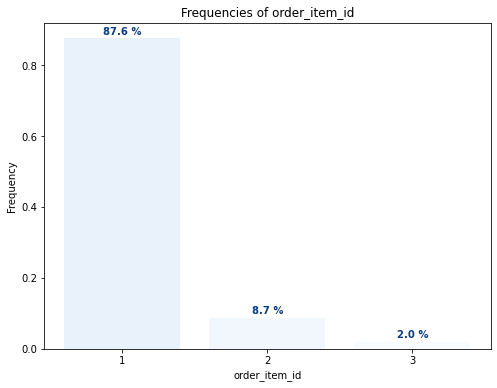

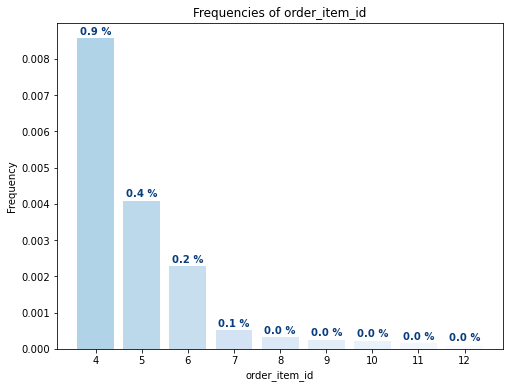

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pepper_commons import value_counts_and_freqs

def plot_freqs_2(data, label, min=0, max=1, c='blue'):
    freq = value_counts_and_freqs(data, label).sort_values(by='count').freq
    num_colors = len(freq)
    freq = freq[(min <= freq) & (freq <= max)]
    num_bars = len(freq)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(f'Frequencies of {label}')
    ax.set_xlabel(label)
    ax.set_ylabel('Frequency')
    ax.set_xticks(np.arange(0, 100, 1))
    #ax.set_ylim([0, 1])
    
    # Create a color map using a gradient of colors
    cmap = plt.cm.get_cmap('Blues')
    colors = [cmap(i / num_colors) for i in range(num_colors)]
    #colors = colors[::-1]
    
    # Plot the frequencies
    bars = ax.bar(freq.index, freq.values, color=colors, alpha=0.8)
    
    # Add labels to the bars
    ax.bar_label(
        bars,
        labels=[f'{round(100*f, 1)} %' for f in freq.values],
        padding=2,
        fontweight='bold', fontsize=10, c=colors[-1]
    )
    
    plt.show()


plot_freqs_2(raw_order_items, 'order_item_id', min=.01)
plot_freqs_2(raw_order_items, 'order_item_id', max=.01, min=.0001)

# Sphinx documentation

**https://www.sphinx-doc.org/en/master/usage/quickstart.html**


https://copyassignment.com/python-docstring-generator-pycharm-and-vscode/

https://marketplace.visualstudio.com/items?itemName=njpwerner.autodocstring


https://artflag.github.io/sphinxtechnicalwriting/tools/custo.html

[Youtube : Extending VSCode: Build Documentation with Python Sphinx](https://www.youtube.com/watch?v=v2nLuDpigDA)



file:///C:/Users/franc/Projects/pepper_olist_market_segmentation/_build/html/index.html

https://www.sphinx-doc.org/en/master/usage/quickstart.html#setting-up-the-documentation-sources

C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\Scripts


In [52]:
%pip install sphinx

In [54]:
import os
print(os.getcwd())
os.chdir('..')
print(os.getcwd())

c:\Users\franc\Projects\pepper_olist_market_segmentation\jupyter
c:\Users\franc\Projects\pepper_olist_market_segmentation


PS C:\Users\franc\Projects\pepper_olist_market_segmentation> conda activate base
conda : Le terme «conda» n'est pas reconnu comme nom d'applet de commande, fonction, fichier de script ou programme 
exécutable. Vérifiez l'orthographe du nom, ou si un chemin d'accès existe, vérifiez que le chemin d'accès est correct et 
réessayez.
Au caractère Ligne:1 : 1
+ conda activate base
+ ~~~~~
    + CategoryInfo          : ObjectNotFound: (conda:String) [], CommandNotFoundException
    + FullyQualifiedErrorId : CommandNotFoundException
 
PS C:\Users\franc\Projects\pepper_olist_market_segmentation> sphinx-quickstart
sphinx-quickstart : Le terme «sphinx-quickstart» n'est pas reconnu comme nom d'applet de commande, fonction, fichier de 
script ou programme exécutable. Vérifiez l'orthographe du nom, ou si un chemin d'accès existe, vérifiez que le chemin       
d'accès est correct et réessayez.
Au caractère Ligne:1 : 1
+ sphinx-quickstart
+ ~~~~~~~~~~~~~~~~~
    + CategoryInfo          : ObjectNotFound: (sphinx-quickstart:String) [], CommandNotFoundException
    + FullyQualifiedErrorId : CommandNotFoundException

PS C:\Users\franc\Projects\pepper_olist_market_segmentation> pip install sphinx
Collecting sphinx
  Downloading sphinx-5.3.0-py3-none-any.whl (3.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8.1 MB/s eta 0:00:00
Requirement already satisfied: packaging>=21.0 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (21.3)
Collecting Pygments>=2.12
  Downloading Pygments-2.13.0-py3-none-any.whl (1.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.7 MB/s eta 0:00:00
Collecting sphinxcontrib-jsmath
  Downloading sphinxcontrib_jsmath-1.0.1-py2.py3-none-any.whl (5.1 kB)
Collecting alabaster<0.8,>=0.7
  Downloading alabaster-0.7.12-py2.py3-none-any.whl (14 kB)
Collecting sphinxcontrib-applehelp
  Downloading sphinxcontrib_applehelp-1.0.2-py2.py3-none-any.whl (121 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 3.6 MB/s eta 0:00:00
Collecting colorama>=0.4.5
  Downloading colorama-0.4.6-py2.py3-none-any.whl (25 kB)
Collecting babel>=2.9
  Downloading Babel-2.11.0-py3-none-any.whl (9.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 8.9 MB/s eta 0:00:00
Collecting snowballstemmer>=2.0
  Downloading snowballstemmer-2.2.0-py2.py3-none-any.whl (93 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 5.5 MB/s eta 0:00:00
Collecting sphinxcontrib-devhelp
  Downloading sphinxcontrib_devhelp-1.0.2-py2.py3-none-any.whl (84 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 4.7 MB/s eta 0:00:00
Collecting sphinxcontrib-serializinghtml>=1.1.5
  Downloading sphinxcontrib_serializinghtml-1.1.5-py2.py3-none-any.whl (94 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 5.2 MB/s eta 0:00:00
Collecting docutils<0.20,>=0.14
  Downloading docutils-0.19-py3-none-any.whl (570 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 6.0 MB/s eta 0:00:00
Collecting Jinja2>=3.0
  Downloading Jinja2-3.1.2-py3-none-any.whl (133 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 7.7 MB/s eta 0:00:00
Requirement already satisfied: requests>=2.5.0 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (2.28.1)
Collecting sphinxcontrib-qthelp
  Downloading sphinxcontrib_qthelp-1.0.3-py2.py3-none-any.whl (90 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 2.5 MB/s eta 0:00:00
Collecting imagesize>=1.3
  Downloading imagesize-1.4.1-py2.py3-none-any.whl (8.8 kB)
Collecting sphinxcontrib-htmlhelp>=2.0.0
  Downloading sphinxcontrib_htmlhelp-2.0.0-py2.py3-none-any.whl (100 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 5.6 MB/s eta 0:00:00
Requirement already satisfied: pytz>=2015.7 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from babel>=2.9->sphinx) (2022.2.1)
Collecting MarkupSafe>=2.0
  Downloading MarkupSafe-2.1.1-cp310-cp310-win_amd64.whl (17 kB)
Requirement already satisfied: pyparsing!=3.0.5,>=2.0.2 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from packaging>=21.0->sphinx) (3.0.9)
Requirement already satisfied: urllib3<1.27,>=1.21.1 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from requests>=2.5.0->sphinx) (1.26.11)
Requirement already satisfied: certifi>=2017.4.17 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from requests>=2.5.0->sphinx) (2022.6.15)
Requirement already satisfied: charset-normalizer<3,>=2 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from requests>=2.5.0->sphinx) (2.1.0)
Requirement already satisfied: idna<4,>=2.5 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from requests>=2.5.0->sphinx) (3.3)
Installing collected packages: snowballstemmer, alabaster, sphinxcontrib-serializinghtml, sphinxcontrib-qthelp, sphinxcontrib-jsmath, sphinxcontrib-htmlhelp, sphinxcontrib-devhelp, sphinxcontrib-applehelp, Pygments, MarkupSafe, imagesize, docutils, colorama, babel, Jinja2, sphinx
  WARNING: The script pygmentize.exe is installed in 'C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\Scripts' which is not on PATH.
PS C:\Users\franc\Projects\pepper_olist_market_segmentation> sphinx-quickstart
sphinx-quickstart : Le terme «sphinx-quickstart» n'est pas reconnu comme nom d'applet de commande, fonction, fichier de      script ou programme exécutable. Vérifiez l'orthographe du nom, ou si un chemin d'accès existe, vérifiez que le chemin        
d'accès est correct et réessayez.
Au caractère Ligne:1 : 1+ sphinx-quickstart
+ ~~~~~~~~~~~~~~~~~
    + CategoryInfo          : ObjectNotFound: (sphinx-quickstart:String) [], CommandNotFoundException    + FullyQualifiedErrorId : CommandNotFoundException

PS C:\Users\franc\Projects\pepper_olist_market_segmentation> pip install -U sphinx
Requirement already satisfied: sphinx in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (5.3.0)
Requirement already satisfied: alabaster<0.8,>=0.7 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (0.7.12)
Requirement already satisfied: sphinxcontrib-applehelp in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (1.0.2)
Requirement already satisfied: docutils<0.20,>=0.14 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (0.19)
Requirement already satisfied: sphinxcontrib-serializinghtml>=1.1.5 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (1.1.5)
Requirement already satisfied: snowballstemmer>=2.0 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (2.2.0)
Requirement already satisfied: colorama>=0.4.5 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (0.4.6)
Requirement already satisfied: Pygments>=2.12 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (2.13.0)
Requirement already satisfied: babel>=2.9 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (2.11.0)
Requirement already satisfied: sphinxcontrib-htmlhelp>=2.0.0 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (2.0.0)
Requirement already satisfied: sphinxcontrib-qthelp in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (1.0.3)
Requirement already satisfied: requests>=2.5.0 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (2.28.1)
Requirement already satisfied: sphinxcontrib-devhelp in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (1.0.2)
Requirement already satisfied: packaging>=21.0 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (21.3)
Requirement already satisfied: sphinxcontrib-jsmath in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (1.0.1)
Requirement already satisfied: Jinja2>=3.0 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (3.1.2)
Requirement already satisfied: imagesize>=1.3 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from sphinx) (1.4.1)
Requirement already satisfied: pytz>=2015.7 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from babel>=2.9->sphinx) (2022.2.1)
Requirement already satisfied: MarkupSafe>=2.0 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from Jinja2>=3.0->sphinx) (2.1.1)
Requirement already satisfied: pyparsing!=3.0.5,>=2.0.2 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from packaging>=21.0->sphinx) (3.0.9)
Requirement already satisfied: idna<4,>=2.5 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from requests>=2.5.0->sphinx) (3.3)
Requirement already satisfied: urllib3<1.27,>=1.21.1 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from requests>=2.5.0->sphinx) (1.26.11)
Requirement already satisfied: charset-normalizer<3,>=2 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from requests>=2.5.0->sphinx) (2.1.0)
Requirement already satisfied: certifi>=2017.4.17 in c:\users\franc\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages (from requests>=2.5.0->sphinx) (2022.6.15)
PS C:\Users\franc\Projects\pepper_olist_market_segmentation> sphinx-quickstart
sphinx-quickstart : Le terme «sphinx-quickstart» n'est pas reconnu comme nom d'applet de commande, fonction, fichier de 
script ou programme exécutable. Vérifiez l'orthographe du nom, ou si un chemin d'accès existe, vérifiez que le chemin        
d'accès est correct et réessayez.
Au caractère Ligne:1 : 1
+ sphinx-quickstart
+ ~~~~~~~~~~~~~~~~~
    + CategoryInfo          : ObjectNotFound: (sphinx-quickstart:String) [], CommandNotFoundException
    + FullyQualifiedErrorId : CommandNotFoundException

PS C:\Users\franc\Projects\pepper_olist_market_segmentation> python sphinx-quickstart
C:\Users\franc\AppData\Local\Microsoft\WindowsApps\python.exe: can't open file 'C:\\Users\\franc\\Projects\\pepper_olist_market_segmentation\\sphinx-quickstart': [Errno 2] No such file or directory
PS C:\Users\franc\Projects\pepper_olist_market_segmentation> sphinx-quickstart       
sphinx-quickstart : Le terme «sphinx-quickstart» n'est pas reconnu comme nom d'applet de commande, fonction, fichier de 
script ou programme exécutable. Vérifiez l'orthographe du nom, ou si un chemin d'accès existe, vérifiez que le chemin        
d'accès est correct et réessayez.
Au caractère Ligne:1 : 1
+ sphinx-quickstart
+ ~~~~~~~~~~~~~~~~~
    + CategoryInfo          : ObjectNotFound: (sphinx-quickstart:String) [], CommandNotFoundException
    + FullyQualifiedErrorId : CommandNotFoundException

PS C:\Users\franc\Projects\pepper_olist_market_segmentation> C:\Users\franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\Scripts\sphinx-quickstart.exe
Welcome to the Sphinx 5.3.0 quickstart utility.

Please enter values for the following settings (just press Enter to
accept a default value, if one is given in brackets).

Selected root path: .

You have two options for placing the build directory for Sphinx output.
Either, you use a directory "_build" within the root path, or you separate
"source" and "build" directories within the root path.
> Separate source and build directories (y/n) [n]: n

The project name will occur in several places in the built documentation.
> Project name: pepper_olist_market_segmentation
> Author name(s): Franck Lepoivre
> Project release []: 1.0

If the documents are to be written in a language other than English,
you can select a language here by its language code. Sphinx will then
translate text that it generates into that language.


Finished: An initial directory structure has been created.

You should now populate your master file C:\Users\franc\Projects\pepper_olist_market_segmentation\index.rst and create other documentation
source files. Use the Makefile to build the docs, like so:
   make builder
where "builder" is one of the supported builders, e.g. html, latex or linkcheck.

PS C:\Users\franc\Projects\pepper_olist_market_segmentation>

# ✔ Customer reviews scores

Les textes sont hors de portée dans le cadre de ce projet, mais leur analyse pourrait également apporter de l'information.

On se concentre sur les scores.

C'est un élément essentiel de mesure (même si subjective) du niveau de satisfaction client : à mettre en relation bivariée avec plusieurs facteurs.

Les dates ont peut-être leur importance : à ajouter aux intervalles de temps (délai après livraison).

Pourquoi deux dates ? voir la relation entre le délai entre création et score

In [1]:
from olist_commons import get_order_reviews
from pepper_commons import discrete_stats

reviews = get_order_reviews()
display(discrete_stats(reviews))
display(reviews.head(5))

,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
order_reviews,,,,,,
score,99224,5,0,1.000000,0.000050,int32
comment_title,11568,4527,87656,0.116585,0.391338,object
comment_message,40977,36159,58247,0.412975,0.882422,object
creation_date,99224,636,0,1.000000,0.006410,datetime64[ns]
answer_timestamp,99224,98248,0,1.000000,0.990164,datetime64[ns]


order_reviews,score,comment_title,comment_message,creation_date,answer_timestamp
"(order_id, review_id)",,,,,
"(73fc7af87114b39712e6da79b0a377eb, 7bc2406110b926393aa56f80a40eba40)",4,NaN,NaN,2018-01-18,2018-01-18 21:46:59
"(a548910a1c6147796b98fdf73dbeba33, 80e641a11e56f04c1ad469d5645fdfde)",5,NaN,NaN,2018-03-10,2018-03-11 03:05:13
"(f9e4b658b201a9f2ecdecbb34bed034b, 228ce5500dc1d8e020d8d1322874b6f0)",5,NaN,NaN,2018-02-17,2018-02-18 14:36:24
"(658677c97b385a9be170737859d3511b, e64fb393e7b32834bb789ff8bb30750e)",5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
"(8e6bfb81e283fa7e4f11123a3fb894f1, f7c4243c7fe1938f181bec41a392bdeb)",5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


## ✔ Calcul des intervalles temporels

Délais entre les deux dates, et délai avec la livraison, et délai de traitement complet de la commande.

Ici, on a besoin de la table de synthèse COR.

In [2]:
from olist_commons import get_order_and_review_times
from pepper_commons import discrete_stats

times = get_order_and_review_times()
display(discrete_stats(times))
display(times.head(5))

,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
approval_time,99831,33475,161,0.998390,0.335317,float64
carrier_delivering_time,98199,88352,1793,0.982069,0.899724,float64
customer_delivering_time,97005,93809,2987,0.970128,0.967053,float64
processing_estimated_time,99992,96677,0,1.000000,0.966847,float64
approval_to_carrier_delivery_time,98185,87498,1807,0.981929,0.891154,float64
approval_to_customer_delivery_time,96991,93853,3001,0.969988,0.967646,float64
approval_to_estimated_delivery_time,99831,92338,161,0.998390,0.924943,float64
transit_time,97004,92239,2988,0.970118,0.950878,float64
estimated_transit_time,98199,81053,1793,0.982069,0.825395,float64
delivery_advance_time,97005,91915,2987,0.970128,0.947528,float64


,,,approval_time,carrier_delivering_time,customer_delivering_time,processing_estimated_time,approval_to_carrier_delivery_time,approval_to_customer_delivery_time,approval_to_estimated_delivery_time,transit_time,estimated_transit_time,delivery_advance_time,delivery_to_review_time,review_time
"(_ident_, order_id)","(_ident_, customer_id)","(_ident_, review_id)",,,,,,,,,,,,
00e7ee1b050b8499577073aeb2a297a1,861eff4711a542e4b93843c6dd7febb0,88b8b52d46df026a9d1ad2136a59b30b,0.011539,6.821088,8.812500,19.371123,6.809549,8.800961,19.359583,1.991412,12.550035,10.558623,0.558623,4.940741
29150127e6685892b6eab3eec79f59c7,290c77bc529b7ac935b93aa66c333dc3,02fc48a9efa3e3d0f1a8ea26507eeec3,0.007037,2.851794,16.661748,24.133056,2.844757,16.654711,24.126019,13.809954,21.281262,7.471308,0.471308,11.946863
b2059ed67ce144a36e2aa97d2c9e9ad2,060e732b5b29e8181a18229c7b0b2b5e,5ad6695d76ee186dc473c42706984d87,1.007928,22.932813,26.077153,24.327951,21.924884,25.069225,23.320023,3.144340,1.395139,-1.749201,0.250799,0.507627
951670f92359f4fe4a63112aa7306eba,259dac757896d24d7702b9acbbff3f3c,059a801bb31f6aab2266e672cab87bc5,0.057419,14.302824,14.998461,27.328727,14.245405,14.941042,27.271308,0.695637,13.025903,12.330266,0.330266,4.775544
6b7d50bd145f6fc7f33cebabd7e49d0f,345ecd01c38d18a9036ed96c73b8d066,8490879d58d6c5d7773f2739a03f089a,0.012951,1.225347,11.461319,16.589236,1.212396,11.448368,16.576285,10.235972,15.363889,5.127917,0.127917,7.083241


## ✔ Agrégation centrée utilisateur

✔ Most customers only ordered once. For a feature like a delay, it's hard to find more relevant than an average, which will return the single value in most cases.

In [3]:
from olist_commons import get_customer_order_and_review_times
from pepper_commons import discrete_stats

customer_times = get_customer_order_and_review_times()
display(discrete_stats(customer_times))
display(customer_times)

,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
approval_time,95997,33913,99,0.998970,0.353271,float64
carrier_delivering_time,94466,86022,1630,0.983038,0.910613,float64
customer_delivering_time,93356,90950,2740,0.971487,0.974228,float64
processing_estimated_time,96096,93672,0,1.000000,0.974775,float64
approval_to_carrier_delivery_time,94453,85282,1643,0.982903,0.902904,float64
approval_to_customer_delivery_time,93343,90985,2753,0.971352,0.974738,float64
approval_to_estimated_delivery_time,95997,89764,99,0.998970,0.935071,float64
transit_time,93355,89551,2741,0.971476,0.959252,float64
estimated_transit_time,94466,79056,1630,0.983038,0.836873,float64
delivery_advance_time,93356,89270,2740,0.971487,0.956232,float64


,approval_time,carrier_delivering_time,customer_delivering_time,processing_estimated_time,approval_to_carrier_delivery_time,approval_to_customer_delivery_time,approval_to_estimated_delivery_time,transit_time,estimated_transit_time,delivery_advance_time,delivery_to_review_time,review_time
"(_ident_, customer_id)",,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.010313,1.889965,6.411227,10.544132,1.879653,6.400914,10.533819,4.521262,8.654167,4.132905,0.132905,4.572778
0000b849f77a49e4a4ce2b2a4ca5be3f,0.301586,2.046215,3.285590,7.533715,1.744630,2.984005,7.232130,1.239375,5.487500,4.248125,0.248125,0.937095
0000f46a3911fa3c0805444483337064,0.000000,2.662118,25.731759,27.121493,2.662118,25.731759,27.121493,23.069641,24.459375,1.389734,0.389734,1.055370
0000f6ccb0745a6a4b88665a16c9f078,0.013611,0.985162,20.037083,31.146053,0.971551,20.023472,31.132442,19.051921,30.160891,11.108970,0.108970,1.012396
0004aac84e0df4da2b147fca70cf8255,0.014699,2.004491,13.141134,20.176597,1.989792,13.126435,20.161898,11.136644,18.172106,7.035463,0.035463,4.937211
...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.010185,14.668646,27.514861,54.124583,14.658461,27.504676,54.114398,12.846215,39.455937,26.609722,0.609722,4.472280
fffea47cd6d3cc0a88bd621562a9d061,0.005833,10.846586,30.097500,32.161157,10.840752,30.091667,32.155324,19.250914,21.314572,2.063657,0.063657,5.494433
ffff371b4d645b6ecea244b27531430a,0.009352,0.760660,14.872083,44.340787,0.751308,14.862731,44.331435,14.111424,43.580127,29.468704,0.468704,2.627326


### ✔ Customer satisfaction

✔ Most customers only ordered once, and for a feature like the review score, it is important to highlight customer dissatisfaction as it can be rare but has a significant impact on customer retention. Knowing that more than 50% of customers gave the maximum score, it is crucial to take into account any dissatisfaction as even a single instance can ruin all efforts to ensure customer satisfaction. To highlight this, we calculate a weighted average of the scores, with respective weights of 5, 4, 3, 2, 1 for the scores 1, 2, 3, 4, 5.

In [4]:
from olist_commons import get_customer_satisfaction
from pepper_commons import discrete_stats

customer_satisfaction = get_customer_satisfaction()
display(discrete_stats(customer_satisfaction))

customer_satisfaction.index.name = 'customer_id'
customer_satisfaction.columns = ['satisfaction']
display(customer_satisfaction)

,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
satisfaction,95339,37,757,0.992122,0.000388,float64


,satisfaction
customer_id,
0000366f3b9a7992bf8c76cfdf3221e2,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
0000f46a3911fa3c0805444483337064,3.0
0000f6ccb0745a6a4b88665a16c9f078,4.0
0004aac84e0df4da2b147fca70cf8255,5.0
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5.0
fffea47cd6d3cc0a88bd621562a9d061,4.0
ffff371b4d645b6ecea244b27531430a,5.0


## ✔ Ce travail ne peut être complet qu'en prévoyant l'adjonction au fichier client de référence

Avec l'ensemble des features additionnelles envisagées.

Ici, nous ajoutons donc deux features qui nous semblent pertinentes, le niveau satisfaction, et une sélection des délais de traitement, ceux qui nous semblent les plus pertinents :
* approval_time
* customer_delivering_time
* delivery_to_review_time
* review_time

Exemple simple avec la base RFM complétée par des adjonctions.

In [5]:
import pandas as pd
from olist_commons import (
    get_first_order_date,
    get_last_order_date,
    get_customer_RFM
)

crfm = get_customer_RFM(
    relative_to_date=get_last_order_date()
)
display(crfm.sort_values(by='R'))

,R,F,M
customer_id,,,
87ab9fec999db8bd5774917de3cdf01c,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,18.345312,1,137.03
...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,764.087488,1,40.95


In [11]:
import pandas as pd
ext_crfm = pd.concat(
    [
        crfm,
        customer_satisfaction,
        customer_times[[
            'approval_time',
            'customer_delivering_time',
            'delivery_to_review_time',
            'review_time'
        ]]
    ],
    axis=1,
    # join='outer'   # is the default
)
display(ext_crfm)

,R,F,M,satisfaction,approval_time,customer_delivering_time,delivery_to_review_time,review_time
0000366f3b9a7992bf8c76cfdf3221e2,160.273507,1,141.90,5.0,0.010313,6.411227,0.132905,4.572778
0000b849f77a49e4a4ce2b2a4ca5be3f,163.263090,1,27.19,4.0,0.301586,3.285590,0.248125,0.937095
0000f46a3911fa3c0805444483337064,585.850868,1,86.22,3.0,0.000000,25.731759,0.389734,1.055370
0000f6ccb0745a6a4b88665a16c9f078,369.875428,1,43.62,4.0,0.013611,20.037083,0.108970,1.012396
0004aac84e0df4da2b147fca70cf8255,336.905972,1,196.89,5.0,0.014699,13.141134,0.035463,4.937211
...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,495.853958,1,2067.42,5.0,0.010185,27.514861,0.609722,4.472280
fffea47cd6d3cc0a88bd621562a9d061,310.890532,1,84.58,4.0,0.005833,30.097500,0.063657,5.494433
ffff371b4d645b6ecea244b27531430a,617.070162,1,112.46,5.0,0.009352,14.872083,0.468704,2.627326
ffff5962728ec6157033ef9805bacc48,168.092095,1,133.69,5.0,0.028542,11.858854,0.503866,2.636343


# ✔ Adjonction des informations géographiques

Hot encoding.

Mais de quoi ?

Comment relier aux CSP ?

C'est l'algo non supervisé qui va l'établir de lui-même !

Si certains code postaux déterminent des catégories plus intéressantes de clients, alors cela devrait ressortir.

D'ailleurs, au-delà du client individuel, on pourrait passer à l'échelle des secteurs clients, secteurs en termes de géolocalisation.

## ✔ Hot encoding des territoires

States, municipalities, zip codes

Reprendre le code du projet précédent

In [2]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from typing import *

def sort_cols_by_freq(data: pd.DataFrame) -> pd.DataFrame:
    """Returns `data` with columns sorted by decreasing frequency.

    Args:
        - data (pd.DataFrame): DataFrame to sort columns by decreasing frequency.

    Returns:
        - pd.DataFrame: DataFrame with columns sorted by decreasing frequency.
    """
    data.loc['sum'] = data.sum(axis=0)
    sorted_data = data.T.sort_values(by='sum', ascending=False).T
    sorted_data = sorted_data.drop(index='sum')
    return sorted_data


def hot_encode_catvar(
    data: pd.DataFrame,
    cat_var: str,
    new_name: str = None,
    abstractor = None,
    sort: bool = True
) -> pd.DataFrame:
    """Returns one-hot-encoded dataframe of `cat_var` with columns sorted
    by decreasing frequency.

    Args:
        data (DataFrame):
            Dataframe containing the categorical variable.
        cat_var (str):
            The categorical variable to one-hot-encode.
        new_name (str, optional):
            The new column name for the encoded variable.
        abstractor (callable, optional):
            Function to apply on the categorical variable before encoding.
        sort (bool, optional):
            Whether to sort the columns by decreasing frequency.
    """
    # make a copy of the categorical variable and rename if new_name is provided
    cats = data[[cat_var]].copy()
    if new_name is not None:
        cat_var = new_name
        cats.columns = [cat_var]
    # apply the abstractor function if provided
    if abstractor is not None:
        cats[cat_var] = cats[cat_var].apply(abstractor)
    # perform one-hot-encoding
    ohe = OneHotEncoder(handle_unknown='ignore').fit(cats)
    ohe_data = pd.DataFrame.sparse.from_spmatrix(
        ohe.transform(cats),
        index=cats.index,
        columns=ohe.get_feature_names_out()
    ).sparse.to_dense()    # to avoid many warnings
    # sort columns by decreasing frequency if sort is True
    return sort_cols_by_freq(ohe_data) if sort else ohe_data


def abstract_btype(x: str) -> str:
    """Maps building types to the three more abstract classes 'Multifamily',
    'NonResidential' and 'School'

    Args:
        x (str): A building type.

    Returns:
        str: The more abstract class of building type. 
    """
    if 'Multifamily' in x:
        return 'Multifamily'
    elif 'nonresidential' in x.lower():
        return 'NonResidential'
    else:
        return 'School'


def get_abstract_btype(data: pd.DataFrame) -> pd.Series:
    """Apply the abstract_btype function on the 'BuildingType' column
    of the input DataFrame.

    Args:
    - data (pd.DataFrame):
        The input DataFrame containing a 'BuildingType' column
    
    Returns:
    - pd.Series :
        The result of applying the abstract_btype function
        on the 'BuildingType' column
    """
    return data.BuildingType.apply(abstract_btype)


def hot_encode_btype(
    data: pd.DataFrame,
    abstractor: Optional[Callable] = abstract_btype
) -> pd.DataFrame:
    """One hot encode the 'BuildingType' column of the dataframe and return
    the encoded dataframe. Optionally, a function can be provided to abstract
    the building types before encoding.

    Args:
        data (pd.DataFrame):
            The dataframe containing the 'BuildingType' column
        abstractor (Optional[Callable]):
            A function to abstract the building types before encoding.
            (default: abstract_btype)

    Returns:
        pd.DataFrame : the one-hot encoded dataframe
    """
    return hot_encode_catvar(
        data,
        'BuildingType',
        new_name='btype',
        abstractor=abstractor
    )


# exemple d'utilisation, issu du projet précédent (Seattle)
def hot_encode_full_btype(data: pd.DataFrame) -> pd.DataFrame:
    """One-hot encode the "BuildingType" column of the dataframe,
    without abstraction of the building types.

    Args:
    data (pd.DataFrame): Input dataframe.

    Returns:
    pd.DataFrame: One-hot encoded dataframe of "BuildingType" column.
    """
    return hot_encode_catvar(
        data,
        'BuildingType',
        new_name='btype',
        abstractor=None
    )

,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
geolocation,,,,,,
lat,1000163,717372,0,1.0,0.717255,float64
lng,1000163,717615,0,1.0,0.717498,float64
zip_code_prefix,1000163,19015,0,1.0,0.019012,object
city,1000163,5228,0,1.0,0.005227,object
state,1000163,27,0,1.0,0.000027,object


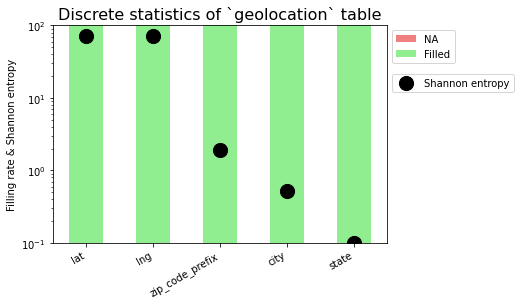

In [1]:
from olist_commons import get_geolocations
from pepper_commons import show_discrete_stats

geolocations = get_geolocations()
show_discrete_stats(geolocations)

In [4]:
states_he = hot_encode_catvar(
        geolocations,
        'state',
        # new_name='btype',
        # abstractor=abstractor
    )

display(states_he)

,state_SP,state_MG,state_RJ,state_RS,state_PR,state_SC,state_BA,state_GO,state_ES,state_PE,...,state_RN,state_PI,state_AL,state_TO,state_SE,state_RO,state_AM,state_AC,state_AP,state_RR
geolocation_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000158,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000159,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000160,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Application aux customers et aux sellers

,n,n_u,n_na,Filling rate,Shannon entropy,dtypes
customers_orders,,,,,,
customer_id,99441,96096,0,1.0,0.966362,object
zip_code_prefix,99441,14994,0,1.0,0.150783,object
city,99441,3892,0,1.0,0.039139,object
state,99441,27,0,1.0,0.000272,object


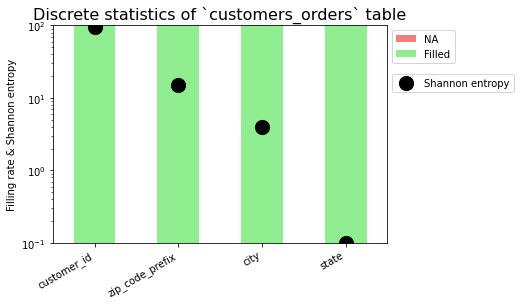

In [27]:
from olist_commons import get_customer_orders
from pepper_commons import show_discrete_stats

customers = get_customer_orders().set_index('customer_id')
show_discrete_stats(customers.reset_index())

n    n_u  n_na  Filling rate  \
object    features                                                    
_ident_   order_id                 99441  99441     0      1.000000   
          customer_id              99441  96096     0      1.000000   
customers zip_code_prefix          99441  14994     0      1.000000   
          city                     99441   3892     0      1.000000   
          state                    99441     27     0      1.000000   
orders    status                   99441      8     0      1.000000   
          purchase_timestamp       99441  98875     0      1.000000   
          approved_at              99281  90733   160      0.998391   
          delivered_carrier_date   97658  81018  1783      0.982070   
          delivered_customer_date  96476  95664  2965      0.970183   
          estimated_delivery_date  99441    459     0      1.000000   

                                   Shannon entropy          dtypes  
object    features                                                  
_ident_   order_id                        1.000000          object  
          customer_id                     0.966362          object  
customers zip_code_prefix                 0.150783          object  
          city                            0.039139          object  
          state                           0.000272          object  
orders    status                          0.000080          object  
          purchase_timestamp              0.994308  datetime64[ns]  
          approved_at                     0.913901  datetime64[ns]  
          delivered_carrier_date          0.829609  datetime64[ns]  
          delivered_customer_date         0.991583  datetime64[ns]  
          estimated_delivery_date         0.004616  datetime64[ns]

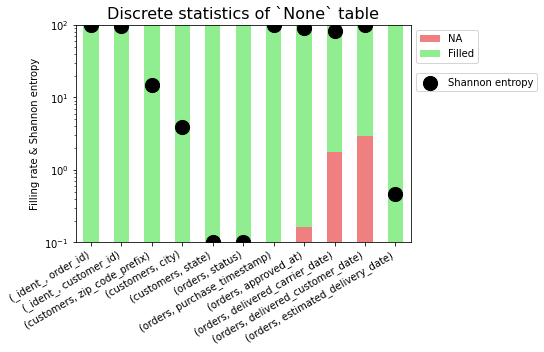

In [28]:
from olist_commons import get_customers_orders
from pepper_commons import show_discrete_stats

co = get_customers_orders() #.set_index('customer_id')
show_discrete_stats(co.reset_index())

In [12]:
# 10^5 x 3.10^1 = 3.10^6 -> 0.2 s
customer_states_he = hot_encode_catvar(
        customers,
        'state',
        # new_name='btype',
        # abstractor=abstractor
    )

display(customer_states_he)

,state_SP,state_RJ,state_MG,state_RS,state_PR,state_SC,state_BA,state_DF,state_ES,state_GO,...,state_PI,state_RN,state_AL,state_SE,state_TO,state_RO,state_AM,state_AC,state_AP,state_RR
customer_id,,,,,,,,,,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290c77bc529b7ac935b93aa66c333dc3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
060e732b5b29e8181a18229c7b0b2b5e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259dac757896d24d7702b9acbbff3f3c,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345ecd01c38d18a9036ed96c73b8d066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d52a67c98be1cf6a5c84435bd38d095d,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e9f50caf99f032f0bf3c55141f019d99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
deduplicated = customer_states_he.reset_index().drop_duplicates(subset='customer_id').set_index('customer_id')
display(deduplicated)

,state_SP,state_RJ,state_MG,state_RS,state_PR,state_SC,state_BA,state_DF,state_ES,state_GO,...,state_PI,state_RN,state_AL,state_SE,state_TO,state_RO,state_AM,state_AC,state_AP,state_RR
customer_id,,,,,,,,,,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290c77bc529b7ac935b93aa66c333dc3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
060e732b5b29e8181a18229c7b0b2b5e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259dac757896d24d7702b9acbbff3f3c,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345ecd01c38d18a9036ed96c73b8d066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d52a67c98be1cf6a5c84435bd38d095d,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e9f50caf99f032f0bf3c55141f019d99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# 10^5 x 4.10^3 = 4.10^8 -> 14 s
customer_cities_he = hot_encode_catvar(
        customers,
        'city',
        # new_name='btype',
        # abstractor=abstractor
    )

display(customer_cities_he)

,city_São Paulo,city_Rio de Janeiro,city_Belo Horizonte,city_Brasília,city_Curitiba,city_Campinas,city_Porto Alegre,city_Salvador,city_Guarulhos,city_São Bernardo do Campo,...,city_Indiaroba,city_Independência,city_Santa Amélia,city_Ilicínea,city_Santa Brígida,city_Ilha Grande,city_Santa Bárbara do Pará,city_Santa Cecília do Pavão,city_Santa Clara d'Oeste,city_Óleo
customer_id,,,,,,,,,,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290c77bc529b7ac935b93aa66c333dc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
060e732b5b29e8181a18229c7b0b2b5e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259dac757896d24d7702b9acbbff3f3c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345ecd01c38d18a9036ed96c73b8d066,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d52a67c98be1cf6a5c84435bd38d095d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e9f50caf99f032f0bf3c55141f019d99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# 10^5 x 15.10^3 = 1,5.10^9 -> 1m52s (6,5 Gb)
# a ne surtout pas mettre en cache !
# faisable, mais couteux
# a du sens après resserrement du ciblage
customer_zips_he = hot_encode_catvar(
        customers,
        'zip_code_prefix',
        # new_name='btype',
        # abstractor=abstractor
    )

display(customer_zips_he)

,zip_code_prefix_22790,zip_code_prefix_24220,zip_code_prefix_22793,zip_code_prefix_24230,zip_code_prefix_22775,zip_code_prefix_29101,zip_code_prefix_13212,zip_code_prefix_35162,zip_code_prefix_22631,zip_code_prefix_38400,...,zip_code_prefix_58487,zip_code_prefix_58465,zip_code_prefix_58463,zip_code_prefix_58432,zip_code_prefix_58429,zip_code_prefix_58421,zip_code_prefix_58411,zip_code_prefix_58398,zip_code_prefix_58396,zip_code_prefix_99990
customer_id,,,,,,,,,,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290c77bc529b7ac935b93aa66c333dc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
060e732b5b29e8181a18229c7b0b2b5e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259dac757896d24d7702b9acbbff3f3c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345ecd01c38d18a9036ed96c73b8d066,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d52a67c98be1cf6a5c84435bd38d095d,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e9f50caf99f032f0bf3c55141f019d99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
del customer_zips_he

Packaging en fonctions

In [44]:
from datetime import datetime
from olist_commons import get_customers_orders, filter_by_dates_in_orders


def get_customer_states_ohe_v2(
    customers_index: Optional[Iterable] = None,
    orders_index: Optional[Iterable] = None,
    from_date: Optional[datetime] = None,
    to_date: Optional[datetime] = None,
    event: Optional[str] = 'purchase'
) -> pd.DataFrame:
    co = get_customers_orders(orders_index, customers_index)
    co_dt = filter_by_dates_in_orders(co, from_date, to_date, event)
    co_dt_locs = (
        co_dt
        .reset_index()
        [[
            ('_ident_', 'customer_id'),
            ('customers', 'state')
        ]]
        .drop_duplicates(subset=('_ident_', 'customer_id'))
    )
    co_dt_locs.columns = ['customer_id', 'state']
    co_dt_locs.set_index('customer_id', inplace=True)
    # returns the state one hot encoding
    return hot_encode_catvar(
        co_dt_locs,
        'state',
        # new_name='btype',
        # abstractor=abstractor
    )


display(get_customer_states_ohe_v2())

,state_SP,state_RJ,state_MG,state_RS,state_PR,state_SC,state_BA,state_DF,state_ES,state_GO,...,state_PI,state_RN,state_AL,state_SE,state_TO,state_RO,state_AM,state_AC,state_AP,state_RR
customer_id,,,,,,,,,,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290c77bc529b7ac935b93aa66c333dc3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
060e732b5b29e8181a18229c7b0b2b5e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259dac757896d24d7702b9acbbff3f3c,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345ecd01c38d18a9036ed96c73b8d066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d52a67c98be1cf6a5c84435bd38d095d,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e9f50caf99f032f0bf3c55141f019d99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
from olist_commons import get_customer_orders
from typing import *


"""customers_index: Optional[Iterable] = None,
orders_index: Optional[Iterable] = None,
from_date: Optional[datetime] = None,
to_date: Optional[datetime] = None,
event: Optional[str] = 'purchase'"""

def get_customer_states_ohe(
    customers_index=None,
    from_date=None,
    to_date=None,
    event=None

) -> pd.DataFrame:
    # deduplicate the few nomads keeping only the first states, if any
    customers = (
        get_customer_orders()
        .drop_duplicates(subset='customer_id')
        .set_index('customer_id')
    )
    # returns the state one hot encoding
    return hot_encode_catvar(
        customers,
        'state',
        # new_name='btype',
        # abstractor=abstractor
    )

display(get_customer_states_ohe())

,state_SP,state_RJ,state_MG,state_RS,state_PR,state_SC,state_BA,state_DF,state_ES,state_GO,...,state_PI,state_RN,state_AL,state_SE,state_TO,state_RO,state_AM,state_AC,state_AP,state_RR
customer_id,,,,,,,,,,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290c77bc529b7ac935b93aa66c333dc3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
060e732b5b29e8181a18229c7b0b2b5e,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
259dac757896d24d7702b9acbbff3f3c,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345ecd01c38d18a9036ed96c73b8d066,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d52a67c98be1cf6a5c84435bd38d095d,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
e9f50caf99f032f0bf3c55141f019d99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## ARI

In [18]:
from sklearn import metrics
labels_true = [0, 0, 0, 1, 1, 1]
labels_pred = [0, 0, 1, 1, 2, 2]
print('RI:', metrics.rand_score(labels_true, labels_pred))
print('ARI:', metrics.adjusted_rand_score(labels_true, labels_pred))


RI: 0.6666666666666666
ARI: 0.24242424242424243


In [19]:
import pandas as pd
from olist_commons import (
    get_last_order_date,
    get_customer_RFM,
)

crfm = get_customer_RFM(
    relative_to_date=get_last_order_date()
)
display(crfm.sort_values(by='R'))

,R,F,M
customer_id,,,
87ab9fec999db8bd5774917de3cdf01c,0.000000,1,89.71
262e1f1e26e92e86375f86840b4ffd63,0.884907,2,444.06
af5454198a97379394cacf676e1e96cb,13.940845,3,592.65
634420a0ea42302205032ed44ac7fccc,16.083437,2,160.76
9bb92bebd4cb7511e1a02d5e50bc4655,18.345312,1,137.03
...,...,...,...
0eb1ee9dba87f5b36b4613a65074337c,744.807245,1,109.34
830d5b7aaa3b6f1e9ad63703bec97d23,762.217824,1,0.00
009b0127b727ab0ba422f6d9604487c7,764.087488,1,40.95


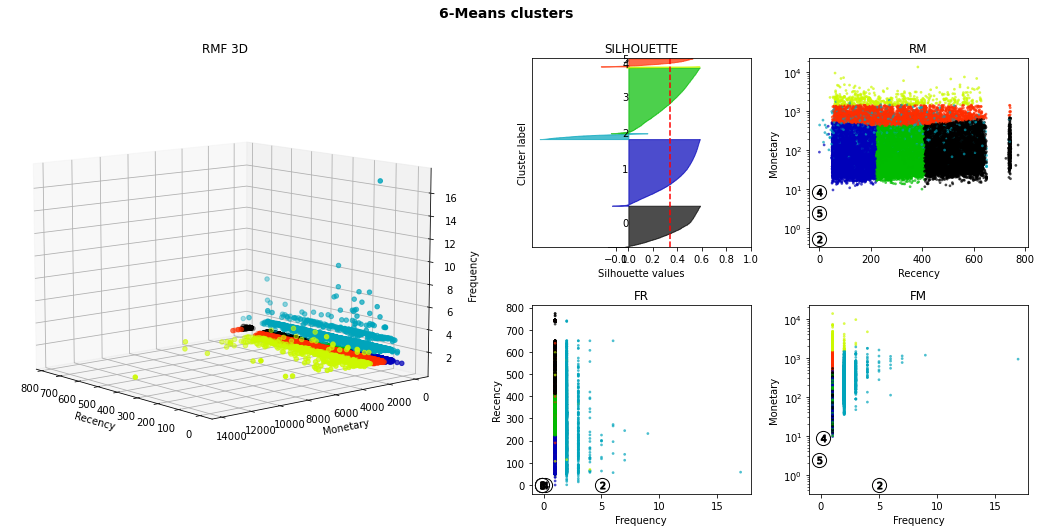

silhouette average : 0.341
k-means fit time : 2.578
silouhette compute time : 348.705


In [20]:
from olist_commons import kmeans_analysis_v2
(
    kmeans, clu_labels, clu_centers, slh_avg, km_t, slh_t
) = kmeans_analysis_v2(crfm, k=6, normalize=True)

In [22]:
from olist_commons import insert_cl_labels
crfm_labeled = insert_cl_labels(crfm, clu_labels, name='k3_clu')
display(crfm_labeled)

,k3_clu,R,F,M
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,160.273507,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,163.263090,1,27.19
0000f46a3911fa3c0805444483337064,0,585.850868,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,3,369.875428,1,43.62
0004aac84e0df4da2b147fca70cf8255,3,336.905972,1,196.89
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,4,495.853958,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,3,310.890532,1,84.58
ffff371b4d645b6ecea244b27531430a,0,617.070162,1,112.46


In [23]:
from olist_commons import get_cl_counts
display(get_cl_counts(crfm_labeled, name='k3_clu'))

1    33920
3    33502
0    21119
5     4082
2     2968
4      505
Name: k3_clu, dtype: int64

In [30]:
"""
	R	F	M
min	max	min	max	min	max
k_clu						
0	398.318935	772.843738	1	6	0.00	521.46
1	0.000000	228.353681	1	5	0.00	365.38
2	0.884907	743.042975	1	17	306.40	958.13
3	60.891458	624.019815	1	4	2564.65	13664.08
4	216.096644	411.294583	1	3	10.07	317.31
5	41.279236	742.920012	1	9	953.84	2512.53
"""


from olist_commons import clusters_business_analysis
import numpy as np
classes_def = {
    0: {'R': [298, 773], 'M': [0, 522]},
    1: {'R': [0, 229], 'M': [0, 366]},
    2: {'R': [0, 744], 'M': [306, 959]},
    3: {'R': [60, 625], 'M': [2564, np.inf]},
    4: {'R': [216, 412], 'M': [10, 318]},
    5: {'R': [41, 743], 'M': [953, 2513]},
}
clusters_business_analysis(crfm, k=6, classes_def=classes_def)


Labeling


,k_clu,R,F,M
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,160.273507,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,163.263090,1,27.19
0000f46a3911fa3c0805444483337064,0,585.850868,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,4,369.875428,1,43.62
0004aac84e0df4da2b147fca70cf8255,4,336.905972,1,196.89
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5,495.853958,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,4,310.890532,1,84.58
ffff371b4d645b6ecea244b27531430a,0,617.070162,1,112.46



Cluster cardinalities


1    33319
4    32881
0    21008
2     7577
5     1222
3       89
Name: k_clu, dtype: int64


Cluster per feature stats
Recency


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,398.318935,772.843738,509.477742,502.251372,69.243767,0.635995,0.143414
1,0.000000,228.353681,135.545575,135.656227,49.824184,-0.011023,-1.285261
2,0.884907,743.042975,274.659473,259.314618,136.631618,0.517627,-0.256474
3,60.891458,624.019815,317.270324,304.343530,187.811433,0.224772,-1.489338
4,216.096644,411.294583,304.455275,306.963032,51.855758,0.177404,-1.035827
5,41.279236,742.920012,290.934218,273.600839,157.075360,0.414063,-0.745517


Monetary


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,0.00,521.46,120.108740,98.845,79.681537,1.216646,1.171179
1,0.00,365.38,118.431063,101.740,72.157836,0.901436,0.218134
2,306.40,958.13,510.044376,458.380,163.622605,0.884294,-0.204456
3,2564.65,13664.08,3660.769326,3064.720,1666.945448,3.511087,15.817621
4,10.07,317.31,110.555326,94.900,66.249157,0.896411,0.133879
5,953.84,2512.53,1402.650368,1296.035,378.465736,0.942229,-0.043523


Frequency (less pertinent)


,min,max,mean,median,std,skew,kurt
k_clu,,,,,,,
0,1,6,1.023991,1.0,0.166721,8.318057,96.858627
1,1,5,1.028302,1.0,0.177550,6.988037,58.636404
2,1,17,1.124720,1.0,0.447795,9.389882,229.564415
3,1,4,1.123596,1.0,0.447727,4.441497,22.449567
4,1,3,1.024269,1.0,0.158751,6.744813,47.716911
5,1,9,1.117840,1.0,0.526941,7.693260,80.308807



Turnover


,toa,tor
k_clu,,
0,2523244.40,0.157615
1,3946004.60,0.246489
2,3864606.24,0.241404
3,325808.47,0.020352
4,3635169.66,0.227072
5,1714038.75,0.107068


,count,min,max,sum,mean,median,std,skew,kurt
k_clu,,,,,,,,,
0,21008,0.00,521.46,2523244.40,120.108740,98.845,79.681537,1.216646,1.171179
1,33319,0.00,365.38,3946004.60,118.431063,101.740,72.157836,0.901436,0.218134
2,7577,306.40,958.13,3864606.24,510.044376,458.380,163.622605,0.884294,-0.204456
3,89,2564.65,13664.08,325808.47,3660.769326,3064.720,1666.945448,3.511087,15.817621
4,32881,10.07,317.31,3635169.66,110.555326,94.900,66.249157,0.896411,0.133879
5,1222,953.84,2512.53,1714038.75,1402.650368,1296.035,378.465736,0.942229,-0.043523



Hypercubic roughing of the domain


R               F            M          
              min         max min max      min       max
k_clu                                                   
0      398.318935  772.843738   1   6     0.00    521.46
1        0.000000  228.353681   1   5     0.00    365.38
2        0.884907  743.042975   1  17   306.40    958.13
3       60.891458  624.019815   1   4  2564.65  13664.08
4      216.096644  411.294583   1   3    10.07    317.31
5       41.279236  742.920012   1   9   953.84   2512.53


Manual sterotyping


,k_cla,R,F,M
customer_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,160.273507,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,1,163.263090,1,27.19
0000f46a3911fa3c0805444483337064,0,585.850868,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,4,369.875428,1,43.62
0004aac84e0df4da2b147fca70cf8255,4,336.905972,1,196.89
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,5,495.853958,1,2067.42
fffea47cd6d3cc0a88bd621562a9d061,4,310.890532,1,84.58
ffff371b4d645b6ecea244b27531430a,0,617.070162,1,112.46



Compare cluster (machine learning) | classes (manual)


,k_clu,k_cla
1,33319,31867
4,32881,34376
0,21008,19666
2,7577,8865
5,1222,1233
3,89,89


In [31]:
from olist_commons import classes_labeling_v1
cla_labels = classes_labeling_v1(crfm, classes_def)
display(cla_labels)

customer_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    0
0000f6ccb0745a6a4b88665a16c9f078    4
0004aac84e0df4da2b147fca70cf8255    4
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    5
fffea47cd6d3cc0a88bd621562a9d061    4
ffff371b4d645b6ecea244b27531430a    0
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    0
Name: label, Length: 96096, dtype: int64

In [32]:
from sklearn import metrics
print('RI:', metrics.rand_score(cla_labels, clu_labels))
print('ARI:', metrics.adjusted_rand_score(cla_labels, clu_labels))

RI: 0.9321751190949641
ARI: 0.8362575882863389


# Algorithme de Hungarian

Objectif : aligner les indices de clusters d'une exécution à la suivante, y compris avec quelques données supplémentaires.

La fonction `scipy.optimize.linear_sum_assignment` est utilisée pour résoudre des problèmes d'affectation de type "minimum de somme linéaire", où l'on a une matrice de coûts et où l'objectif est d'affecter des lignes à des colonnes de manière à minimiser la somme des coûts associés. Pour utiliser cette fonction pour aligner les numéros de clusters d'un k-means entre deux exécutions, vous devriez utiliser une matrice de coûts qui reflète la similitude entre les clusters d'une exécution et les clusters de l'autre exécution.

Pour mettre en oeuvre cette fonction, voici les étapes à suivre :

* Créez une matrice de coûts C de taille (n_clusters1, n_clusters2), où n_clusters1 est le nombre de clusters dans la première exécution et n_clusters2 est le nombre de clusters dans la deuxième exécution. Cette matrice de coûts peut être remplie avec des valeurs de similitude entre les clusters, comme la distance euclidienne entre les centroïdes des clusters.

* Appliquez la fonction scipy.optimize.linear_sum_assignment en lui passant la matrice de coûts C en entrée. Cela renvoie un tuple (row_ind, col_ind) où row_ind et col_ind sont des tableaux d'indices correspondant aux lignes et colonnes de la matrice de coûts qui sont affectées pour minimiser la somme des coûts.

* Utilisez les tableaux row_ind et col_ind pour créer un mapping entre les clusters de la première exécution et les clusters de la deuxième exécution. Pour cela, on peut utiliser la fonction zip pour créer un dictionnaire qui relie les indices des clusters de la première exécution aux indices des clusters de la deuxième exécution.

* Utilisez ce dictionnaire pour aligner les numéros de clusters entre les deux exécutions en remplaçant les numéros de clusters de la première exécution par les numéros de clusters de la deuxième exécution correspondants.